In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

import emcee
import corner

import multiprocessing as mp
from sklearn import preprocessing
from sklearn.neighbors import KernelDensity

%matplotlib inline
%config InlineBackend.figure_format='retina'
#!pip install git+https://github.com/M-Bianchi/My_matplotlib_style
plt.style.use('mystyle')

## Time to get your hands dirty! Supernova distances and redshifts (part 2)

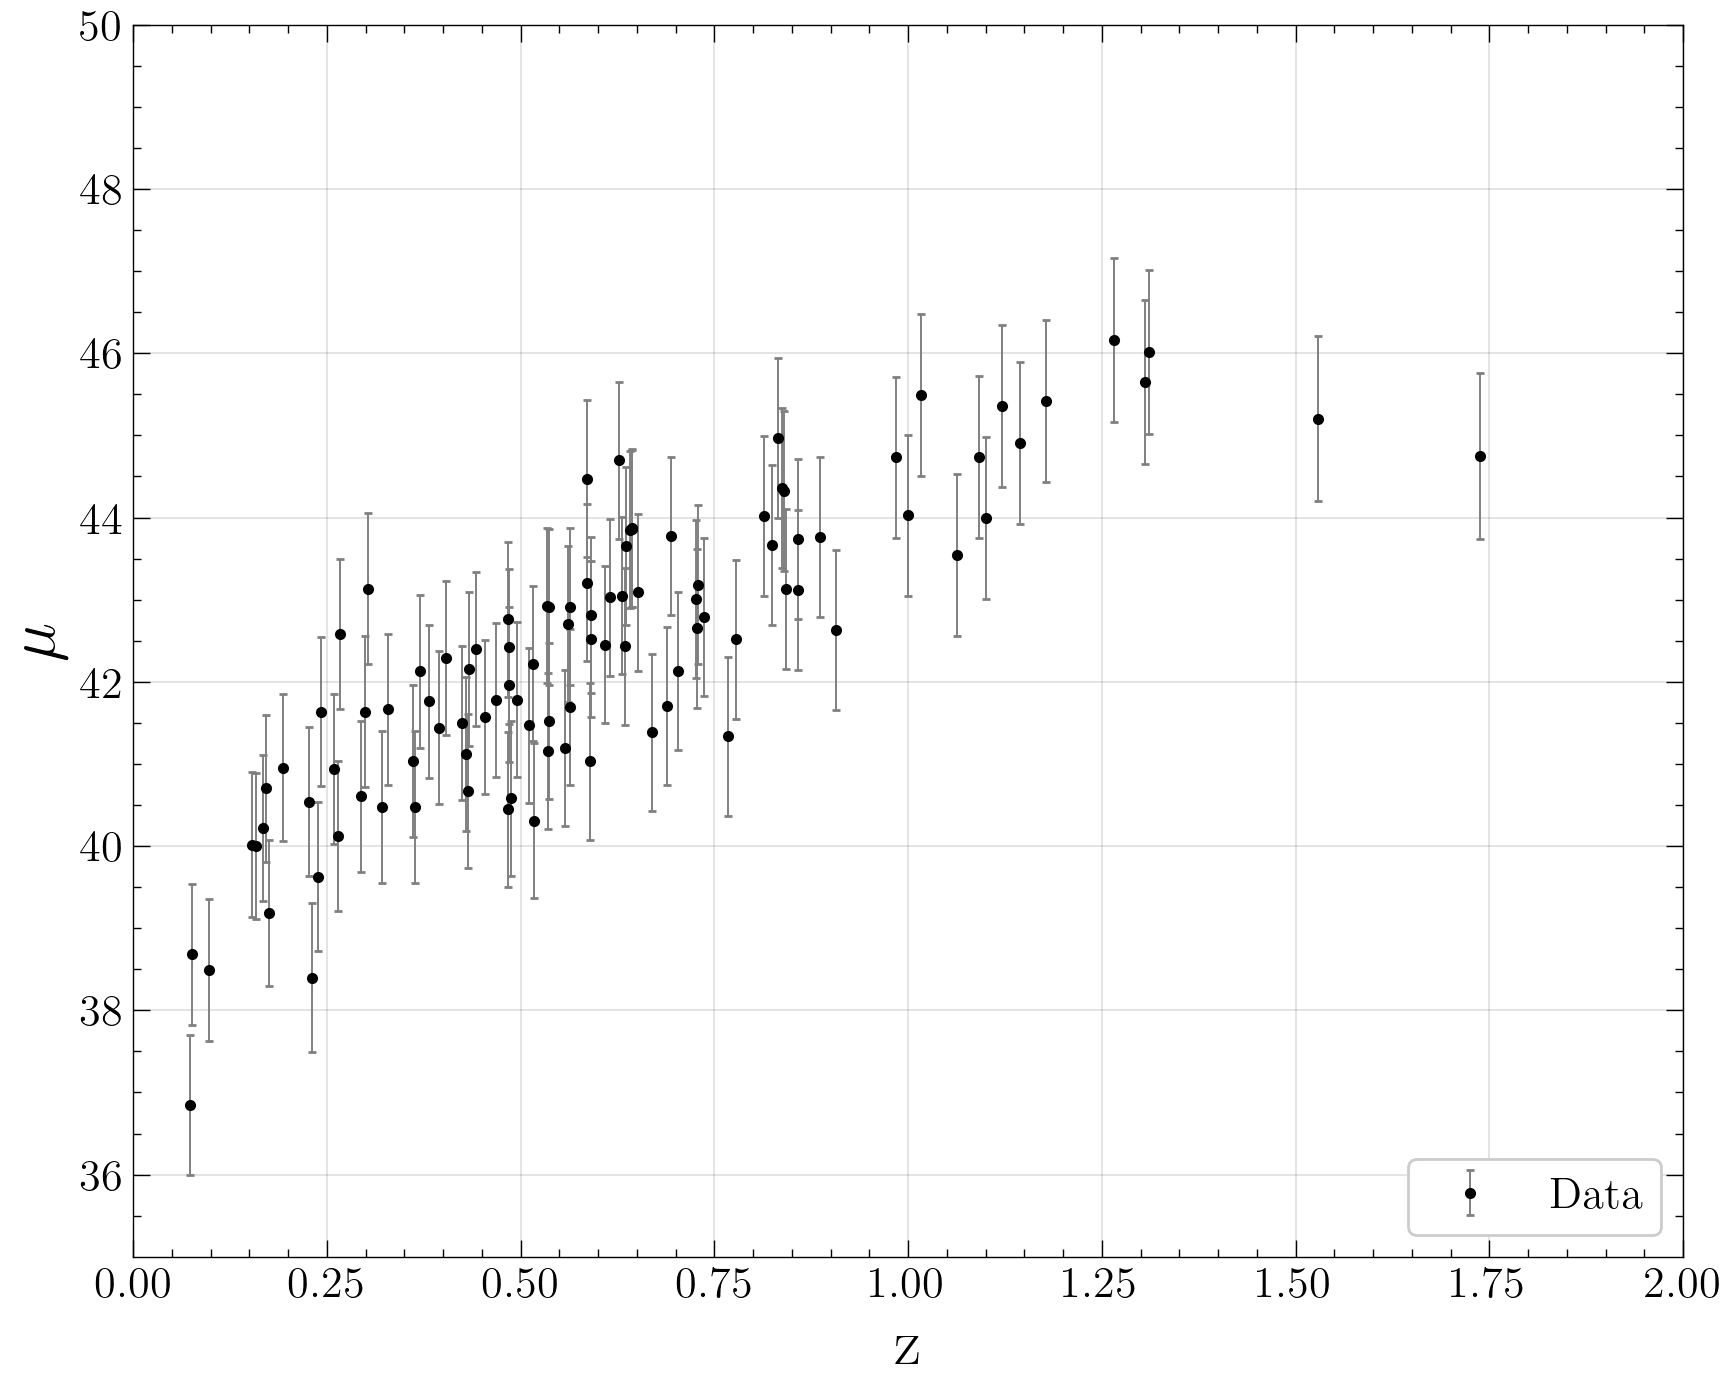

In [2]:
from astroML.datasets import generate_mu_z

N = 100
z_sample, mu_sample, dmu = generate_mu_z(N, random_state=1234)

plt.figure(figsize=(10,8))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=0.7, label='Data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

First let's fit our supernova synthetic data from last time using GPR.

- The key ingredient in getting a good GPR fit is the choice of the kernel and its parameters.
- Check out what's available in the `kernels` submodule of [sklearn.gaussian_process](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process)
- *Hint*. Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
- Interpret the results.

*Note*. We have time constraints, so feel free to tweak the hyperparameters manually while in class. But, of course, a publication-quality result will require a cross-validation analysis. (Do this at home before the exam?)

We now have a suite of **data-driven** predictive models for our supernova dataset (from polynomials to GPR). That is: we can faithfully predict how a future redshift/distance measurement will look like given the current sample.

This is already great and these kind of tools are immensely useful in a variety of contexts (also involving a lot of money: suppose you want to predict how much a give financial asset will perform on tomorrow's stock market... You  might not really care about expressing the underlying financial model in simple terms, as long as your investments are profitable).

For the case of supernovae, however, we have do have physical theory which is $\Lambda$ CDM. We can do a **parametric** fit (and hopehully by now the difference between "parametric" and "data driven" fit is clear in your head)

- First, refresh your cosmology and write down the predicted relationship between the distance module $\mu$ and the redshift $\sigma$. *Hint* I always forget these things, my to-go reference is [Hogg (2010)](https://arxiv.org/abs/astro-ph/9905116). I got:

$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right) $$


- Assuming a flat Universe,  we have a parametric non-linear model for $\mu(z)$ that depends on two parameters, the Hubble constant $H_0$ and the matter content of the Universe $\Omega_m$
- It's a very non-linear model. Fit it to the data (however you want to do it, are you frequentist or Bayesian after all?).
- What are the measured value of $H_0$ and $\Omega_m$. Are they correlated?
- How would a model without dark energy (i.e. $\Omega_m=1$) perform? Do these data contain evidence of dark energy? (Hint: this is a model selection problem!)

The European Space Agency is considering new cosmology-related space mission. They ask you to figure out what science you can do with 10 times more measurement compared to what you have right now. That is: you want to clone your data. We've seen this earlier in the class, but now we can do much much better.
- Think about the pdf of these data in $z$.
- Using both the GPR fit and your latest $\Lambda$ CDM fit, generate a set of $\mu$ measurements that respects the statistical properties of the data you were given. 



# Code

## 1) Data-driven fit with Gaussian Process Regression

### 1.1) Radial basis function (aka squared-exponential kernel)

In [3]:
def PlotGPR(gpr, x_data, y_data, y_err):
    gpr.fit(x_data[:, np.newaxis], y_data)
    
    x_dense = np.linspace(0, np.max(x_data)+0.5, 1000)
    y_pred, y_pred_err = gpr.predict(x_dense[:, np.newaxis], return_std=True)

    plt.figure(figsize=(10,8))
    plt.title(f'GPR, Kernel = {gpr.kernel_}')
    plt.errorbar(x_data, y_data, y_err, fmt='.k', ecolor='gray', lw=0.7, label='Data')
    plt.plot(x_dense, y_pred, ls='--', color='red', label='GPR expectation')
    plt.fill_between(x_dense, y_pred - y_pred_err, y_pred + y_pred_err, color='gray', alpha=0.3, label='GPR $1\sigma$')
    plt.fill_between(x_dense, y_pred - 2*y_pred_err, y_pred + 2*y_pred_err, color='gray', alpha=0.15, label='GPR $2\sigma$')
    plt.xlim(0, np.max(x_data)+0.5)
    plt.ylim(36, 50)
    plt.xlabel("z")
    plt.ylabel("$\mu$")
    plt.legend(loc='upper left');
    
    return gpr

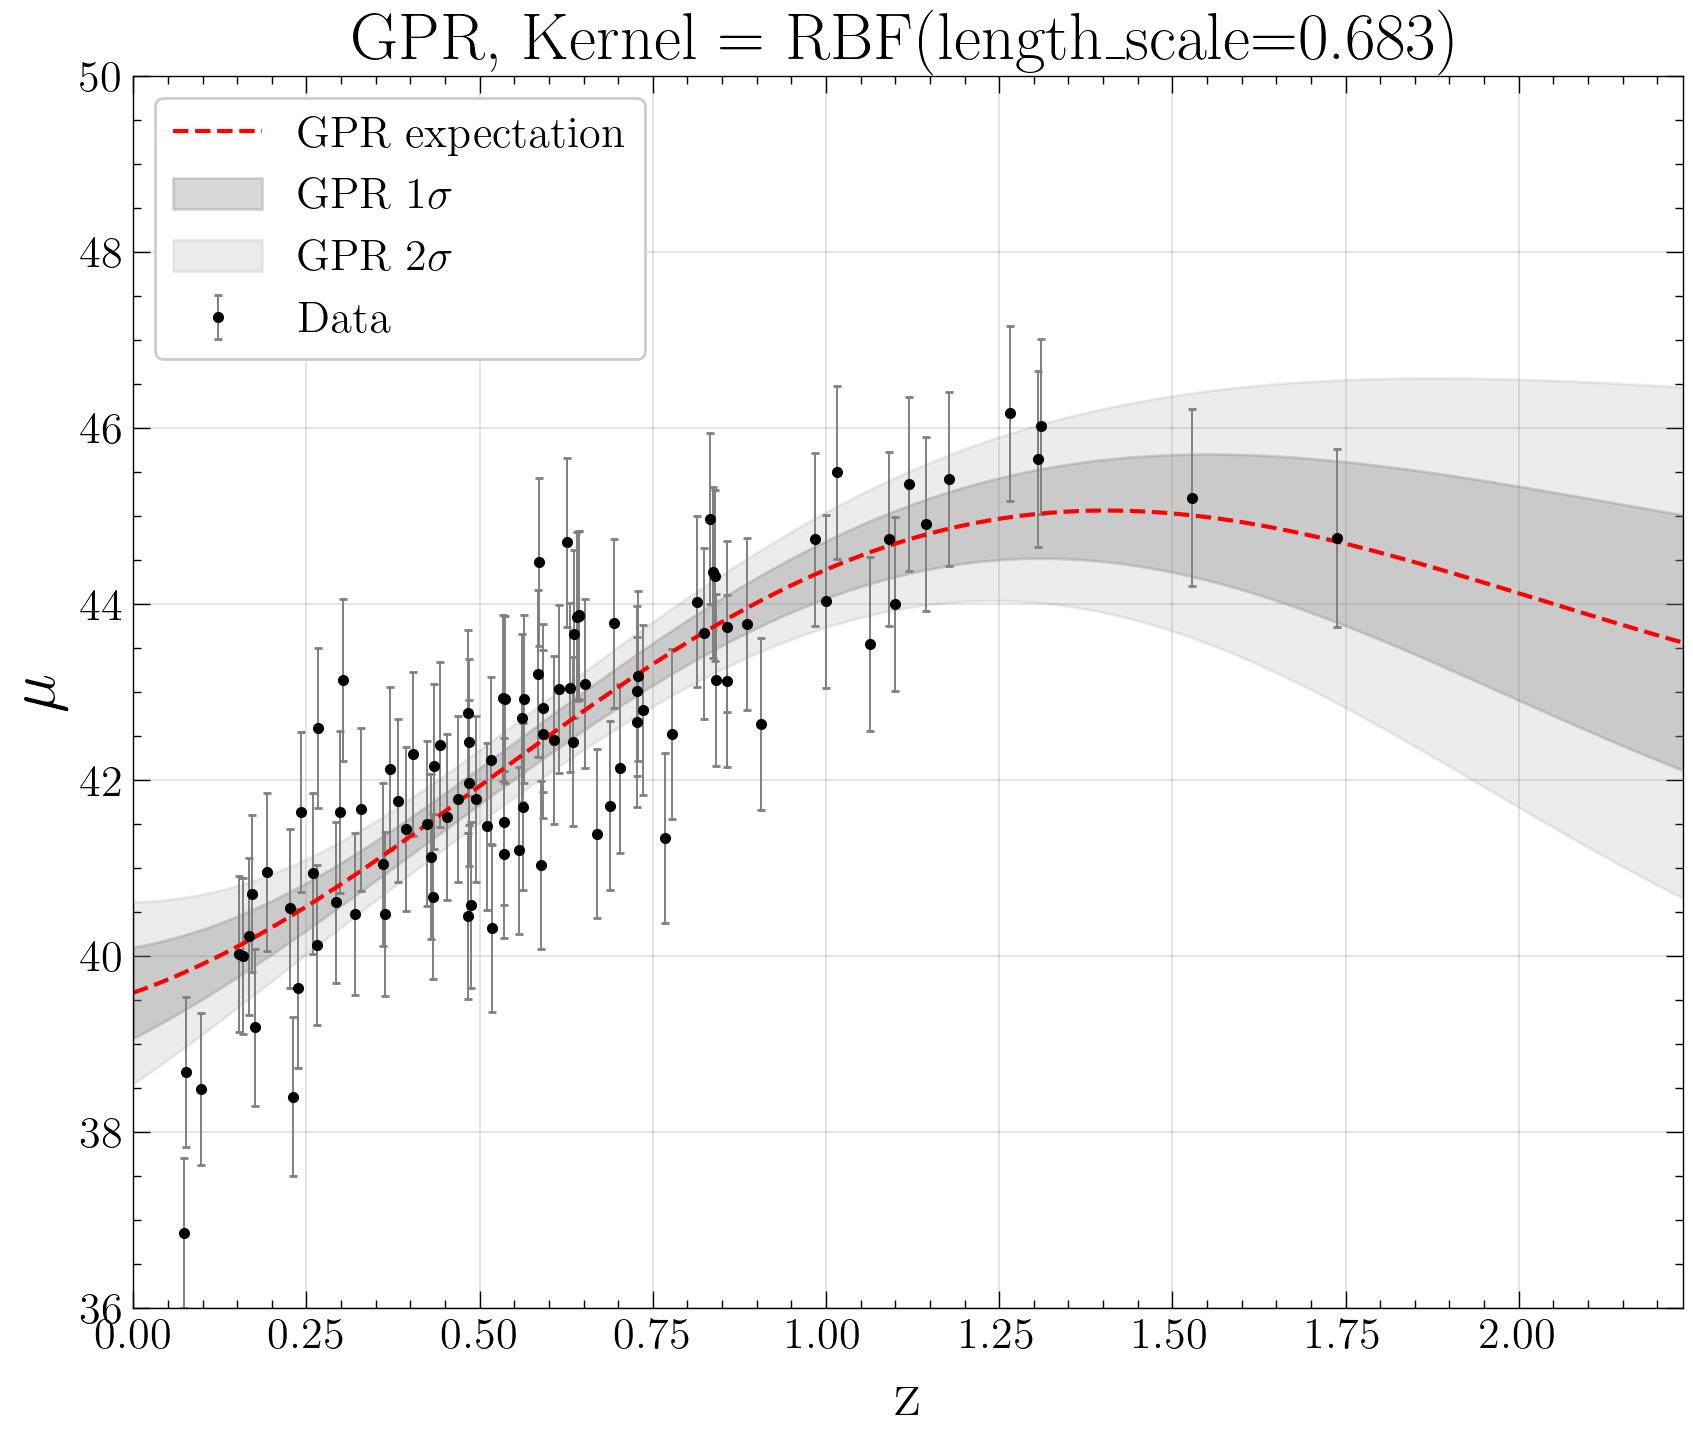

In [4]:
kernel = kernels.RBF(1, [1e-7, 1e7])
gpr = GaussianProcessRegressor(kernel=kernel, alpha=dmu**2, normalize_y=True, n_restarts_optimizer=10)
gpr_fitted = PlotGPR(gpr, z_sample, mu_sample, dmu)

The model accurately captures most of the data, but it fails to describe data for $z\rightarrow 0$ and the slope decreases too much for large redshifts.

Let's see if we can improve the model by carrying out parameter optimization by ourselves, since in the previous case the algorithm did it automatically. \
In order to do it, we have to pass `optimizer=None` to the function and set up a cross-validation routine instead.

In [5]:
kernel_array = [kernels.RBF(length, [1e-7, 1e7]) for length in np.linspace(0.1, 2, 100)]
K = 10
grid = GridSearchCV(GaussianProcessRegressor(alpha=np.mean(dmu**2), normalize_y=True, optimizer=None), 
                    {'kernel': kernel_array}, cv=K, verbose=True)
grid.fit(X=z_sample[:, np.newaxis], y=mu_sample)
kernel_opt = grid.best_params_['kernel']
print(kernel_opt)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
RBF(length_scale=0.925)


For some reason, we have been forced to set `alpha=np.mean(dmu**2)`, which is a bit different from `dmu**2`.

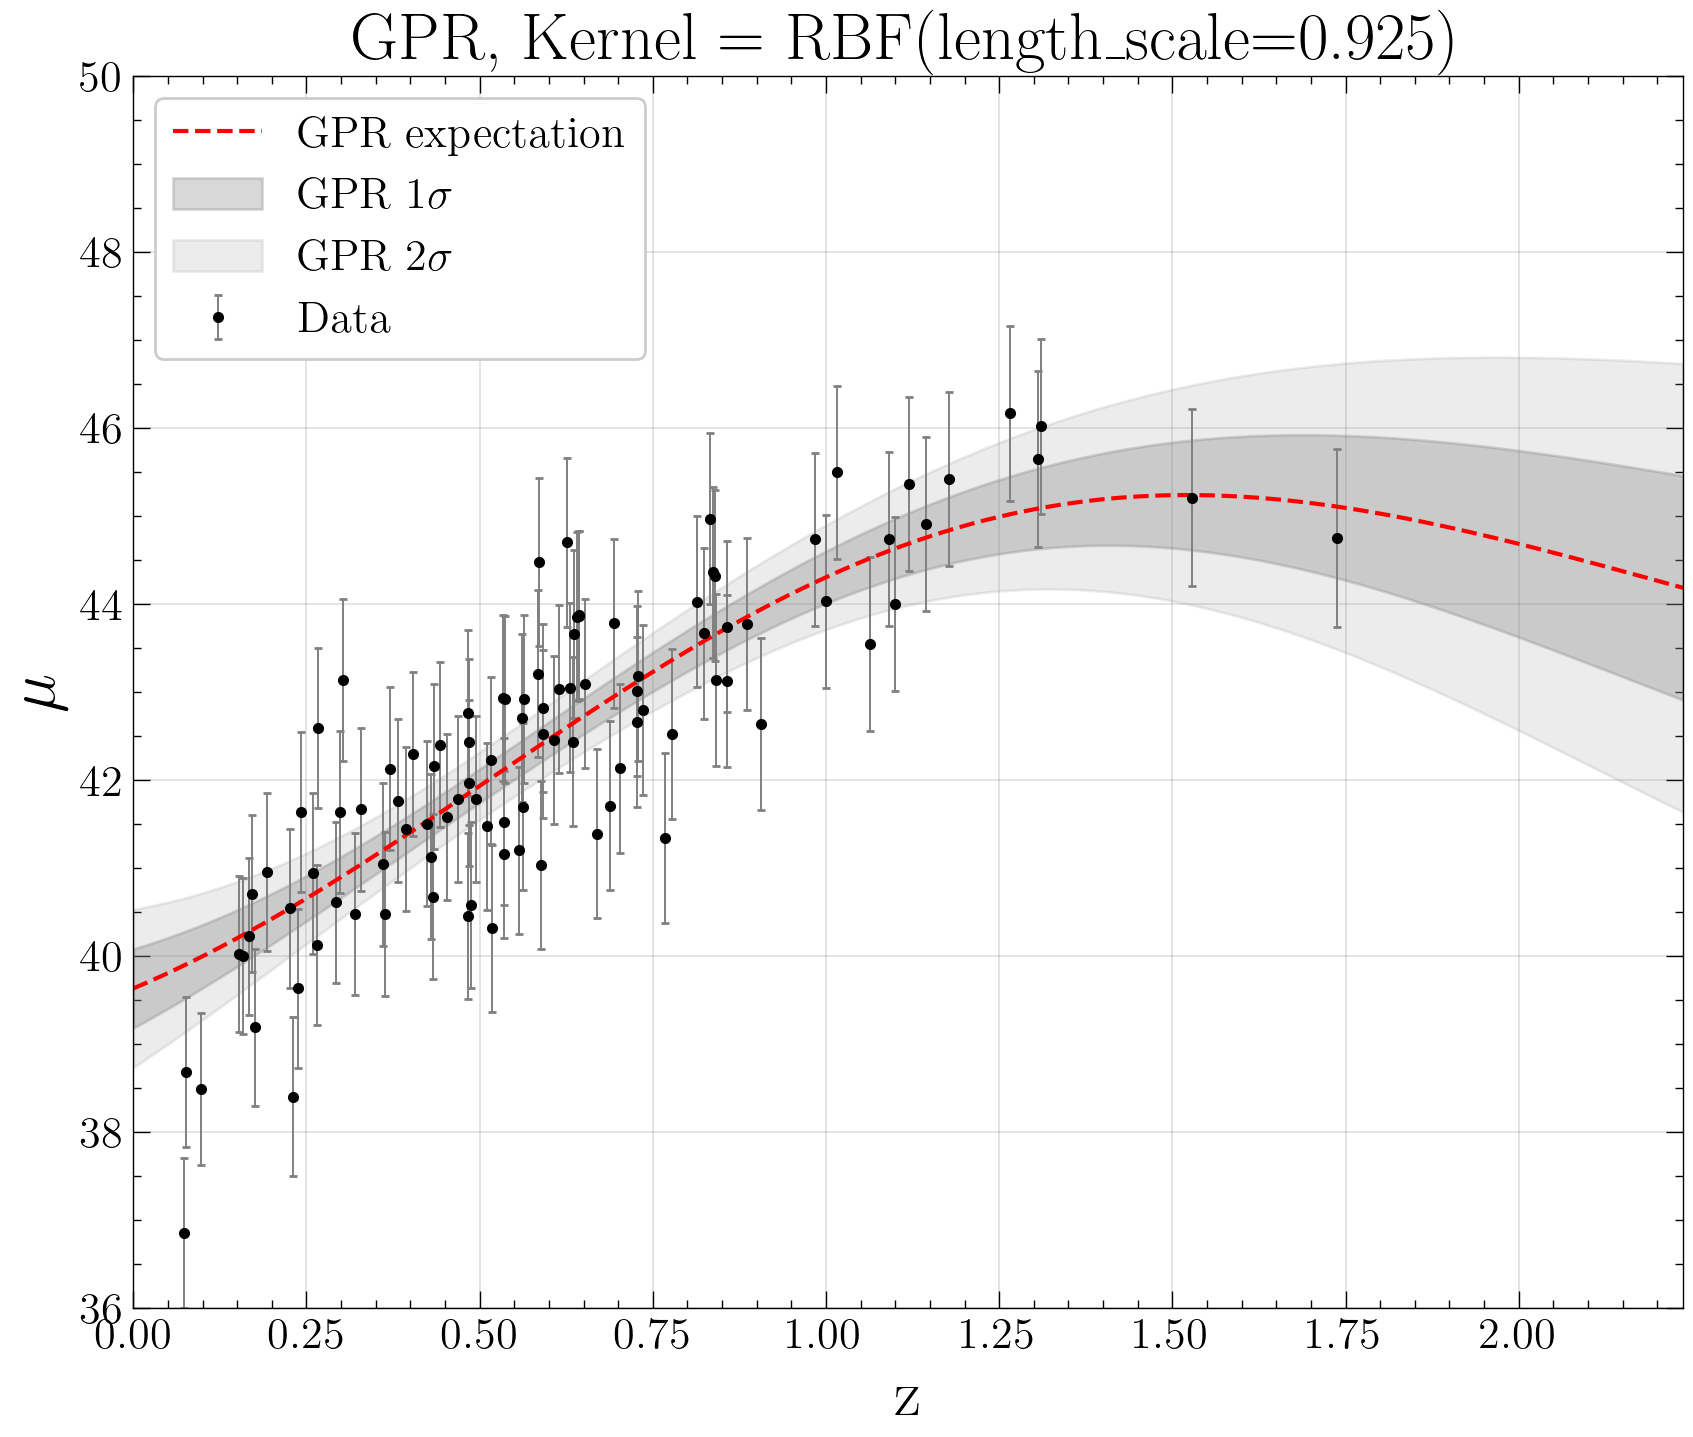

In [6]:
kernel = kernel_opt
gpr = GaussianProcessRegressor(kernel=kernel, alpha=dmu**2, normalize_y=True, optimizer=None)
gpr_fitted = PlotGPR(gpr, z_sample, mu_sample, dmu)

This fit appears to be better than the first one, since the slope changes more gently outside of the data domain.

### 1.2) Radial basis function + Constant

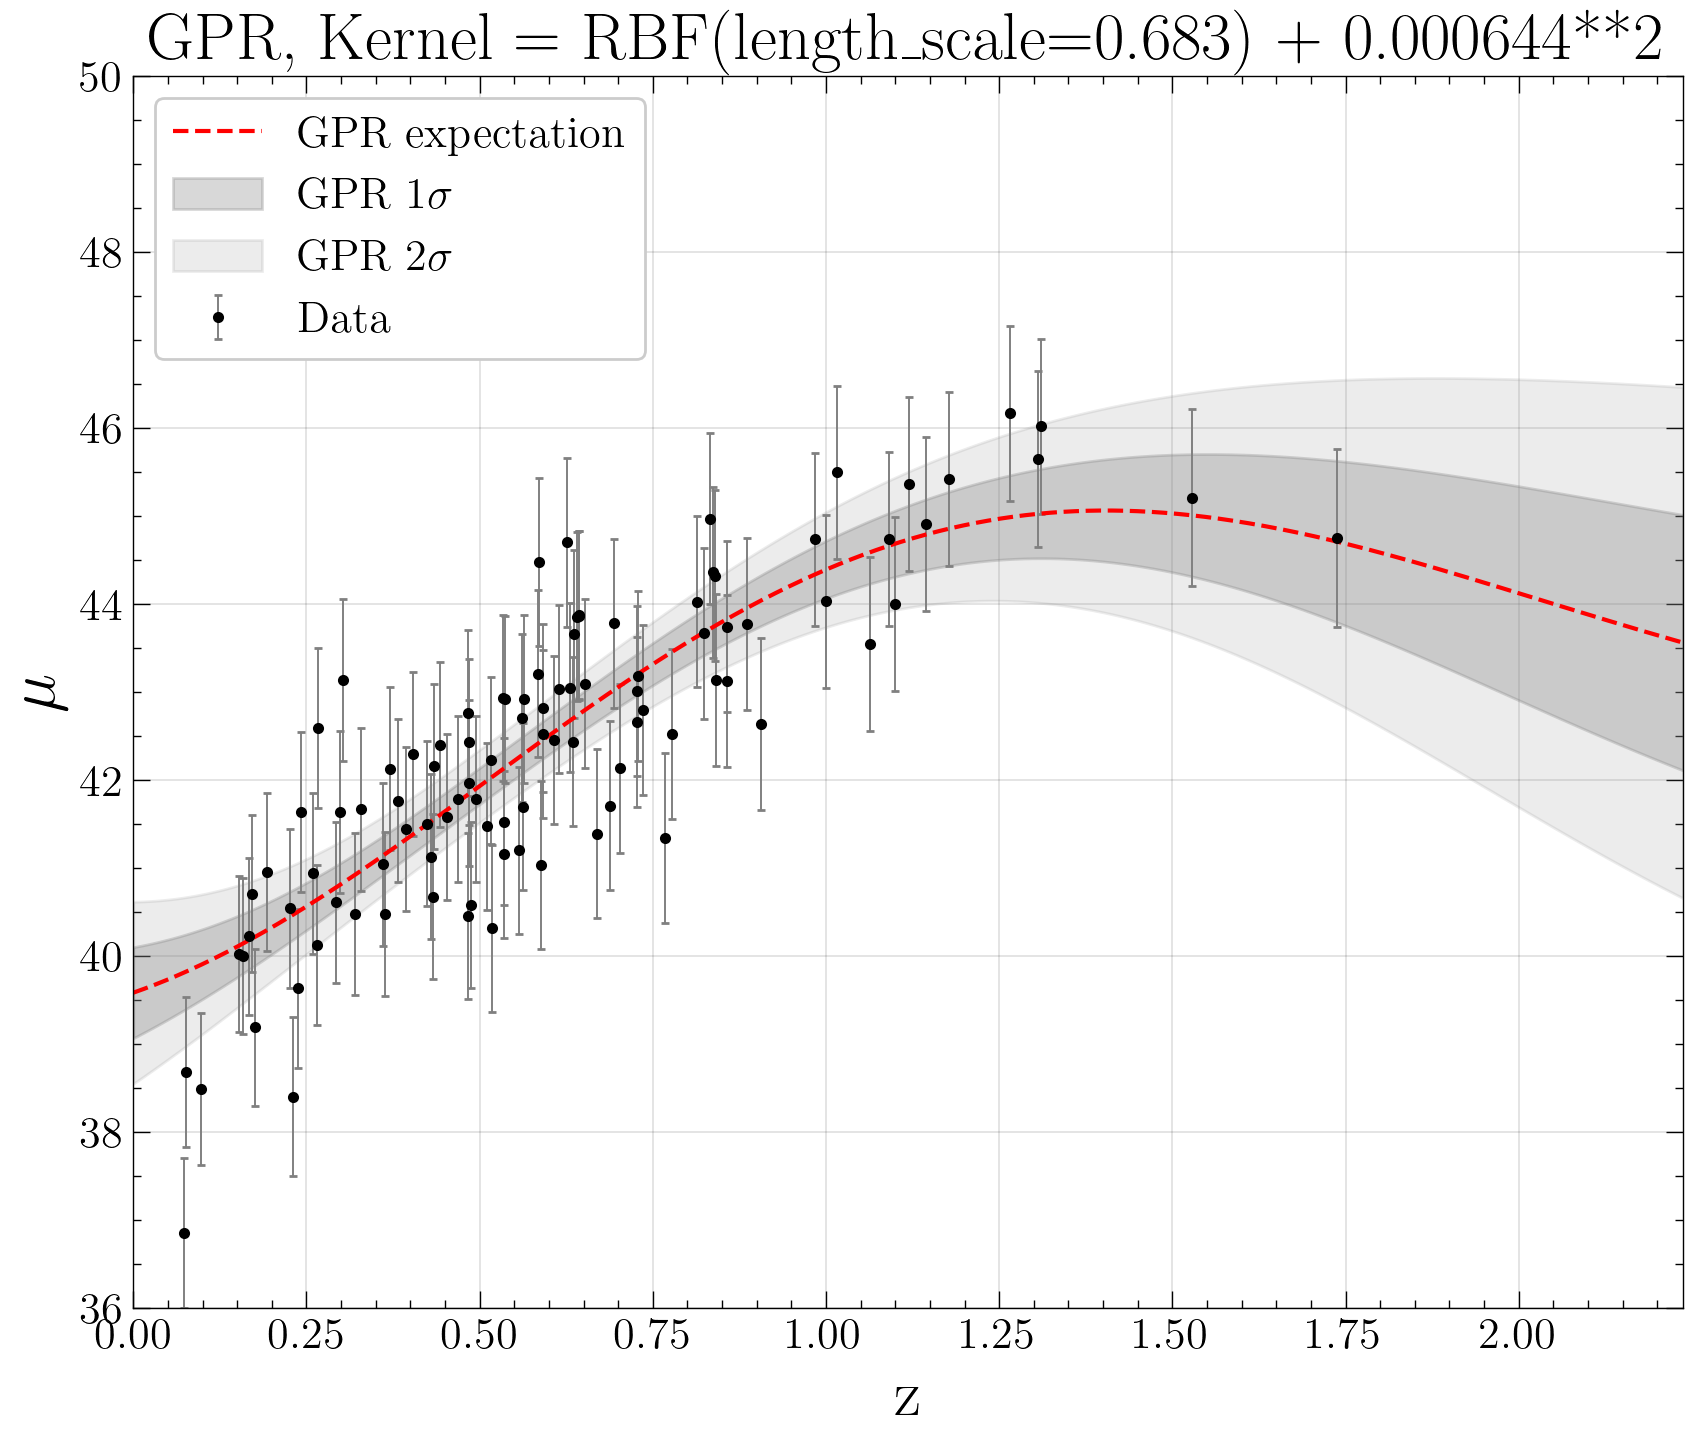

In [7]:
kernel = kernels.RBF(1, [1e-7, 1e7]) + kernels.ConstantKernel(1, [1e-9, 1e7])
gpr = GaussianProcessRegressor(kernel=kernel, alpha=dmu**2, normalize_y=True, n_restarts_optimizer=10)
gpr_fitted = PlotGPR(gpr, z_sample, mu_sample, dmu)

The additive constant turns out to be so small that there is no difference with respect to the first fit.

### 1.3) Radial basis function * Constant

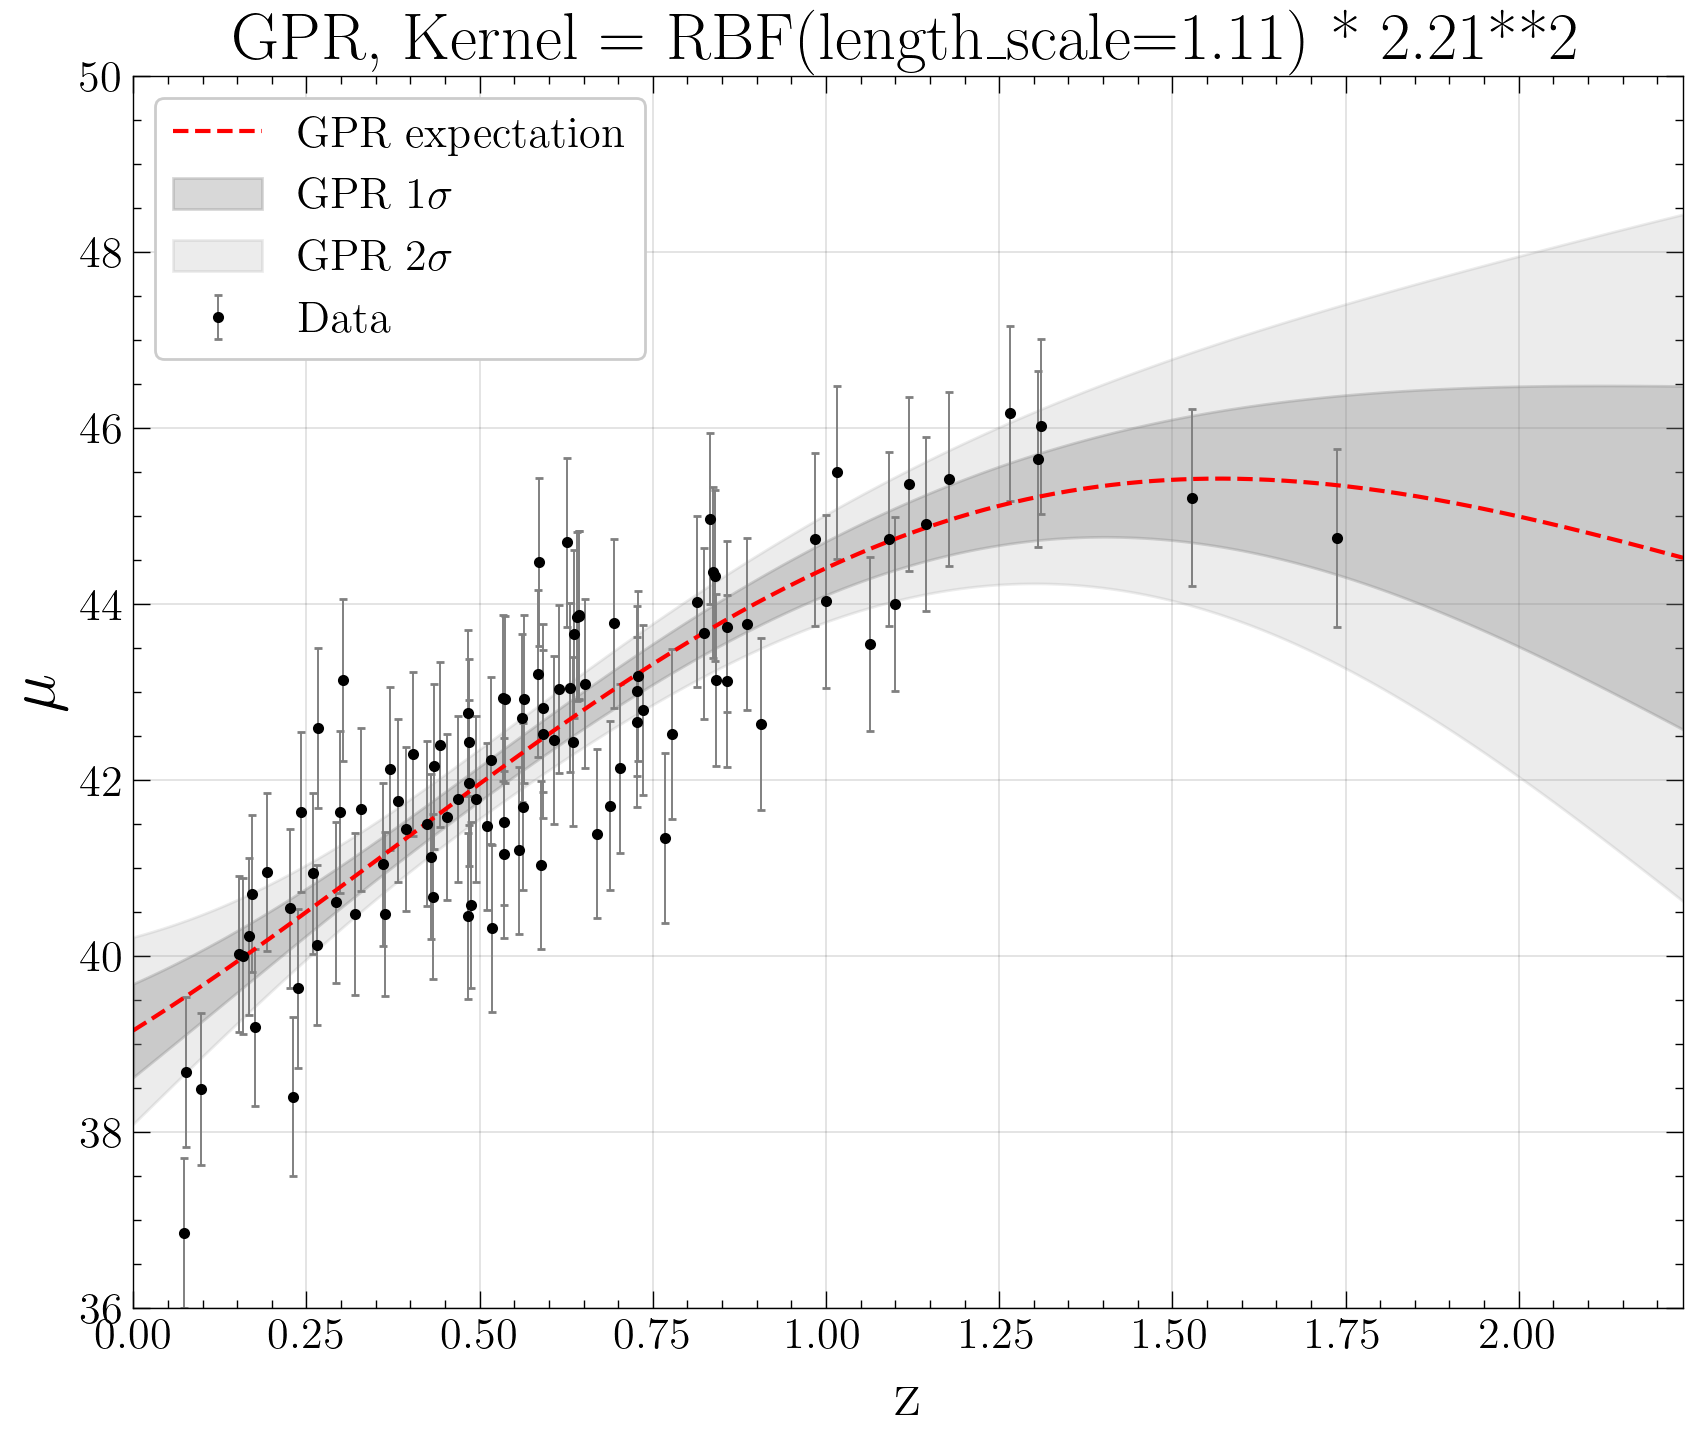

In [8]:
kernel = kernels.RBF(1, [1e-6, 1e6]) * kernels.ConstantKernel(1, [1e-7, 1e7]) 
gpr = GaussianProcessRegressor(kernel=kernel, alpha=dmu**2, normalize_y=True, n_restarts_optimizer=10)
gpr_fitted = PlotGPR(gpr, z_sample, mu_sample, dmu)

This is the best fit so far. Let's see if we can further improve it via cross-validation.

In [9]:
import itertools

kernel_array = [kernels.RBF(length, [1e-7, 1e7]) * kernels.ConstantKernel(const, [1e-7, 1e7])  
                for length, const in itertools.product(np.linspace(0.7, 3, 50), np.linspace(0.1, 15, 50))]

K = 10
grid = GridSearchCV(GaussianProcessRegressor(alpha=np.mean(dmu**2), normalize_y=True, optimizer=None), 
                    {'kernel': kernel_array}, cv=K, verbose=True)
grid.fit(X=z_sample[:, np.newaxis], y=mu_sample)
kernel_opt = grid.best_params_['kernel']
print(kernel_opt)

Fitting 10 folds for each of 2500 candidates, totalling 25000 fits
RBF(length_scale=1.64) * 3.87**2


We had to set the `length` of `kernels.RBF()` as >0.7 in order to avoid overfitting.

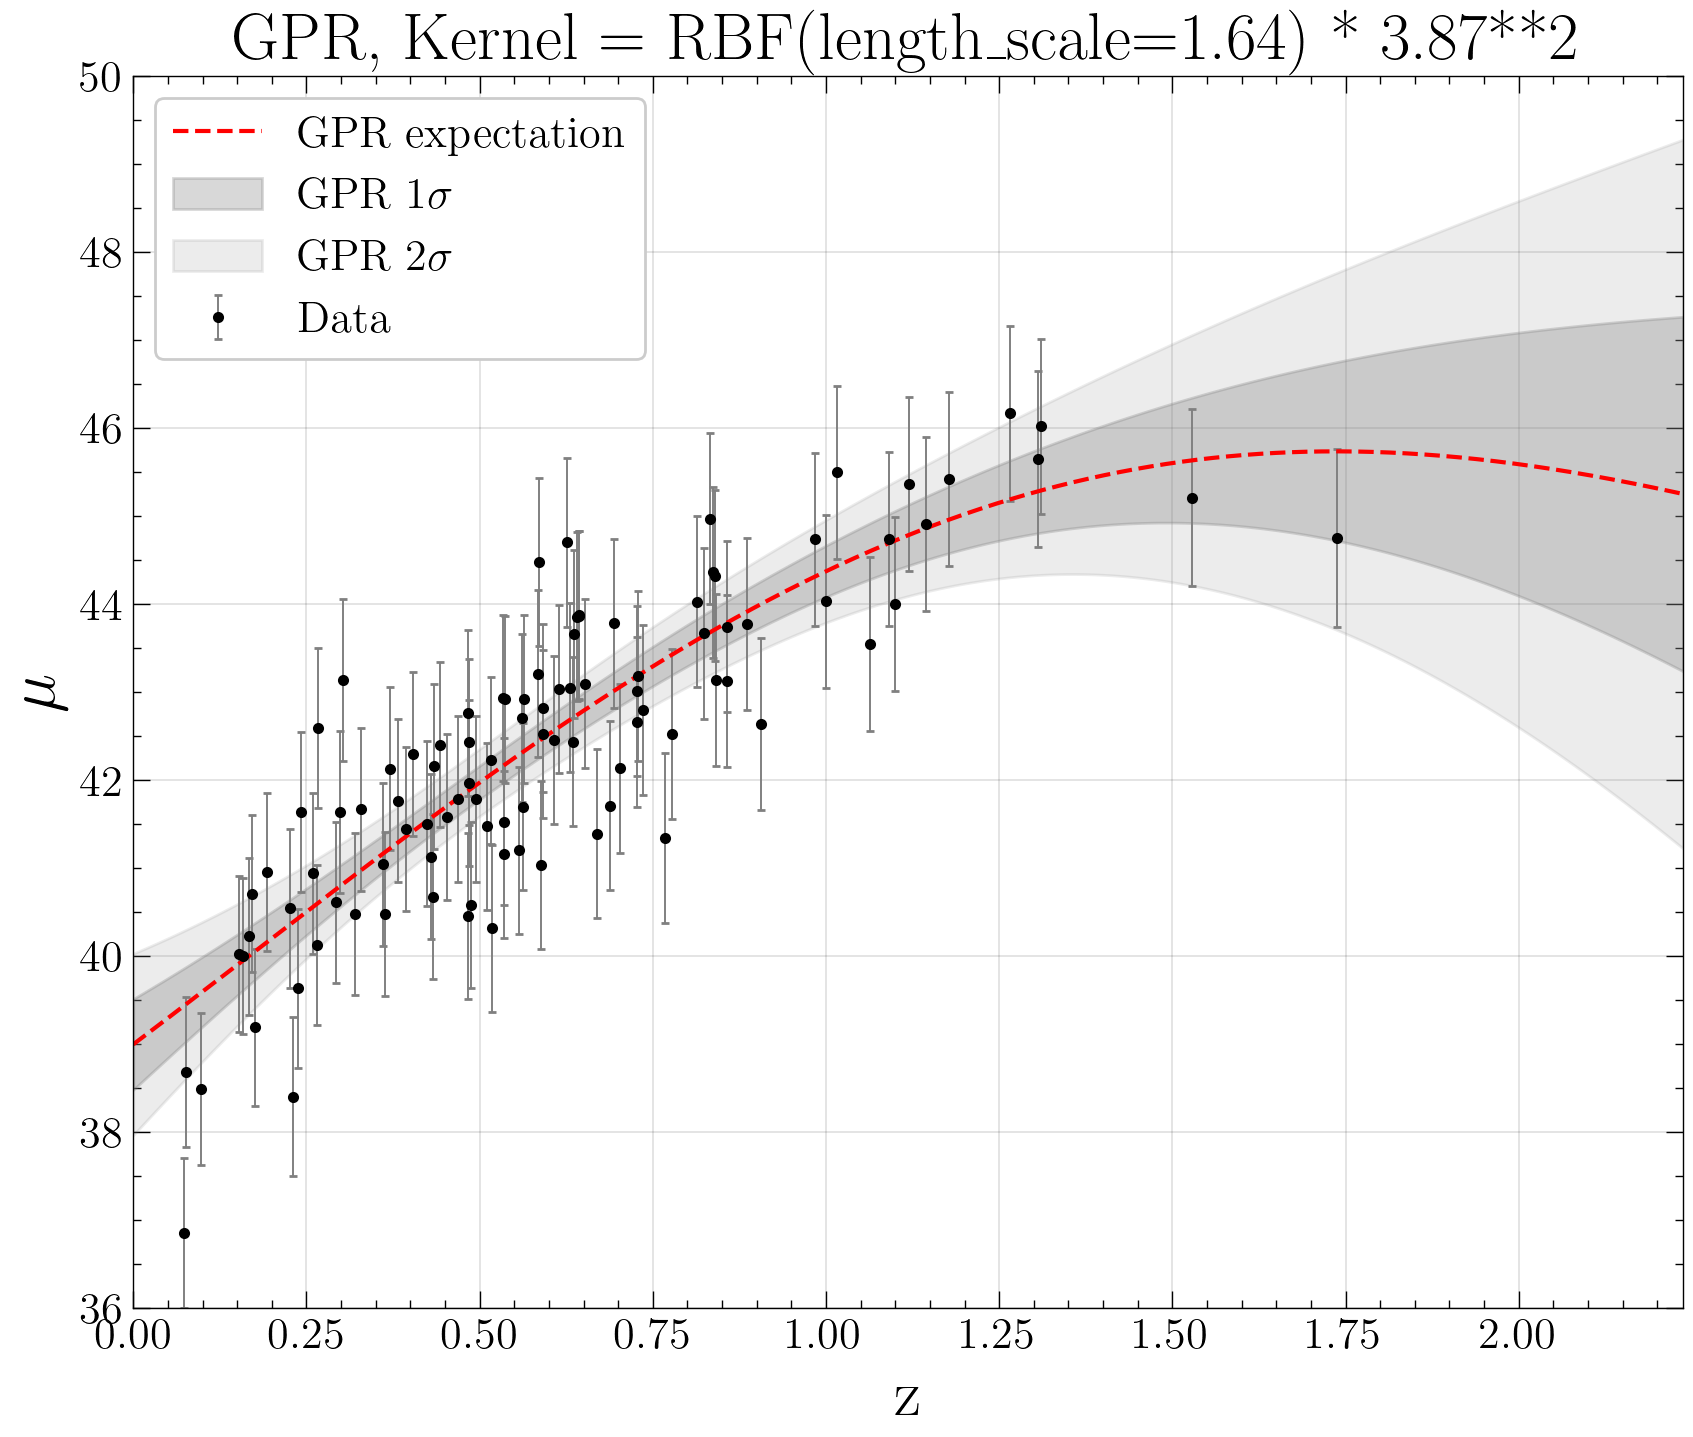

In [10]:
kernel = kernel_opt
gpr = GaussianProcessRegressor(kernel=kernel, alpha=dmu**2, normalize_y=True, optimizer=None)
gpr_fitted = PlotGPR(gpr, z_sample, mu_sample, dmu)

This fit is a little bit better than the previous one.

### 1.4) Cross-validation

In [11]:
kernel_array = [kernels.RBF(1, [1e-7, 1e7]), 
                kernels.RBF(1, [1e-7, 1e7]) + kernels.ConstantKernel(1, [1e-7, 1e7]), 
                kernels.RBF(1, [1e-7, 1e7]) * kernels.ConstantKernel(1, [1e-7, 1e7]),
                kernels.RBF(1, [1e-7, 1e7]) + kernels.RBF(1, [1e-7, 1e7]),
                kernels.RBF(1, [1e-7, 1e7]) * kernels.RBF(1, [1e-7, 1e7]),
                kernels.ExpSineSquared(1, 1, [1e-7, 1e7], [1e-7, 1e7]),
                kernels.RBF(1, [1e-7, 1e7]) + kernels.ExpSineSquared(1, 1, [1e-7, 1e7], [1e-7, 1e7]),
                kernels.Matern(1, [1e-7, 1e7]),
                kernels.RationalQuadratic(1, 1, [1e-7, 1e7], [1e-7, 1e7])]
K = 10
grid = GridSearchCV(GaussianProcessRegressor(alpha=np.mean(dmu**2), normalize_y=True), 
                    {'kernel': kernel_array}, cv=K, verbose=True)
grid.fit(X=z_sample[:, np.newaxis], y=mu_sample)
kernel_opt = grid.best_params_['kernel']
print(kernel_opt)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
RBF(length_scale=1) * 1**2


Cross-validation confirms that `RBF()*ConstantKernel()` is the best model.

## 2) Parametric fit

$$\mu (z) \, = \, 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right)$$

Flat universe $\: \Longrightarrow \:\: \Omega_{tot} \, = \, \Omega_{matter} + \Omega_{radiation} + \Omega_{\Lambda} \, \approx \, \Omega_{matter} + \Omega_{\Lambda} \, \overset{!}{=} \, 1 \:\: \Longrightarrow \:\: \Omega_{\Lambda} \, = \, 1 - \Omega_{matter}$

$$\mu (z) \, = \, 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{1 + \Omega_m z^3}} \right)$$

The integral cannot be solved analytically.

In [12]:
from scipy.integrate import quad

def integrand(x, OmegaM):
    return (1+OmegaM*x**3)**(-0.5)

# The Hubble constant is of the order of 70 (km/s)/Mpc
c = 3e5   # km/s
d = 10e-6 # Mpc

def mu_model(z, H0, OmegaM):
    return 5*np.log10(c/d/H0*(1+z)*quad(integrand, a=0, b=z, args=(OmegaM))[0])

In [13]:
z_test = 0.5
H0_test = 70
OmegaM_test = 0.3

print(f'mu_model(z={z_test:.2f}, H0={H0_test:.1f}, OmegaM={OmegaM_test:.2f}) = {mu_model(z_test, H0_test, OmegaM_test):.2f} makes sense if we look at the plot')

mu_model(z=0.50, H0=70.0, OmegaM=0.30) = 42.53 makes sense if we look at the plot


In [14]:
from astropy.cosmology import LambdaCDM

cosm_model = LambdaCDM(H0=H0_test, Om0=OmegaM_test, Ode0=1-OmegaM_test)
cosm_model.distmod(z_test).value 

42.2611854215409

The value provided by `astropy.cosmology.LambdaCDM` is a little bit different from ours, so we should use that instead.

In [15]:
def mu_model(z, H0, OmegaM):
    cosm_model = LambdaCDM(H0=H0, Om0=OmegaM, Ode0=1-OmegaM)
    return cosm_model.distmod(z).value 

### 2.1) Fit with MCMC

Let's assume a gaussian likelihood. Since we have heteroschedastic uncertainties, then we can compute it as follows:

$$L(H_0, \Omega_m \,|\, \{z_i, \mu_i, \sigma_i\}) = \prod_{i=1}^{N} \dfrac{1}{\sigma_i \sqrt{2\pi}} \, exp\left\{-\dfrac{[\mu_i - f(z_i \,|\, H_0, \Omega_m)]^2}{2\sigma_i^2}\right\}$$

$$\ln\left[L(H_0, \Omega_m \,|\, \{z_i, \mu_i, \sigma_i\})\right] = const - \sum_{i=1}^{N} \dfrac{[\mu_i - f(z_i \,|\, H_0, \Omega_m)]^2}{2\sigma_i^2}$$

In [34]:
def LogLikelihood(params, data_x, data_y, data_yerr):
    H0, OmegaM = params
    if OmegaM<0: return -np.inf
    model_y = mu_model(z=data_x, H0=H0, OmegaM=OmegaM)
    return -np.sum(0.5*np.square((data_y - model_y)/data_yerr))

def Logprior(params):
    H0, OmegaM = params
    if 30 < H0 < 110 and 0.01 < OmegaM < 1.:
        return 0.0
    return -np.inf
                 
def LogPosterior(params, data_x, data_y, data_yerr):
    return LogLikelihood(params, data_x, data_y, data_yerr) + Logprior(params)

In [35]:
ndim = 2         # Number of parameters in the model
nwalkers = 32    # Number of MCMC walkers
nsteps = 10000   # Number of MCMC steps to take **for each walker**

In [36]:
# Initialize the n-dimensional starting point for each walker
starting_guesses = np.array([70, 0.3])
starting_guesses = starting_guesses + 0.05*starting_guesses*np.random.randn(nwalkers, ndim)
print(f'starting_guesses: \n {starting_guesses}')

starting_guesses: 
 [[75.30360855  0.29461448]
 [66.23262641  0.30188046]
 [69.94625256  0.2733208 ]
 [73.90207054  0.26962655]
 [65.13184072  0.31060813]
 [72.51509362  0.32126312]
 [69.75703028  0.29316709]
 [70.67967693  0.28425822]
 [72.59782373  0.29637333]
 [73.09853003  0.27258628]
 [69.25104965  0.2865039 ]
 [73.0911298   0.28177213]
 [66.38034591  0.30235099]
 [67.51217227  0.31279855]
 [71.48250371  0.29877595]
 [75.8685959   0.31315107]
 [60.49136132  0.28691923]
 [66.57508336  0.3287158 ]
 [67.96127748  0.31263991]
 [69.39334544  0.2926515 ]
 [73.02166362  0.27618362]
 [66.87679348  0.28927776]
 [70.84721811  0.30020929]
 [70.38816705  0.29256583]
 [71.25118119  0.3061015 ]
 [73.76497265  0.29059675]
 [68.56430229  0.30411072]
 [69.91186296  0.31737678]
 [72.5023395   0.32092504]
 [72.79357371  0.3122107 ]
 [67.90625731  0.31275196]
 [65.90188753  0.28423844]]


In [37]:
# Initialize and run the MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior, args=[z_sample, mu_sample, dmu])
sampler.run_mcmc(starting_guesses, nsteps);

autocorrelation time = [35.85653515 36.39537276]
chain length = (7776, 2)


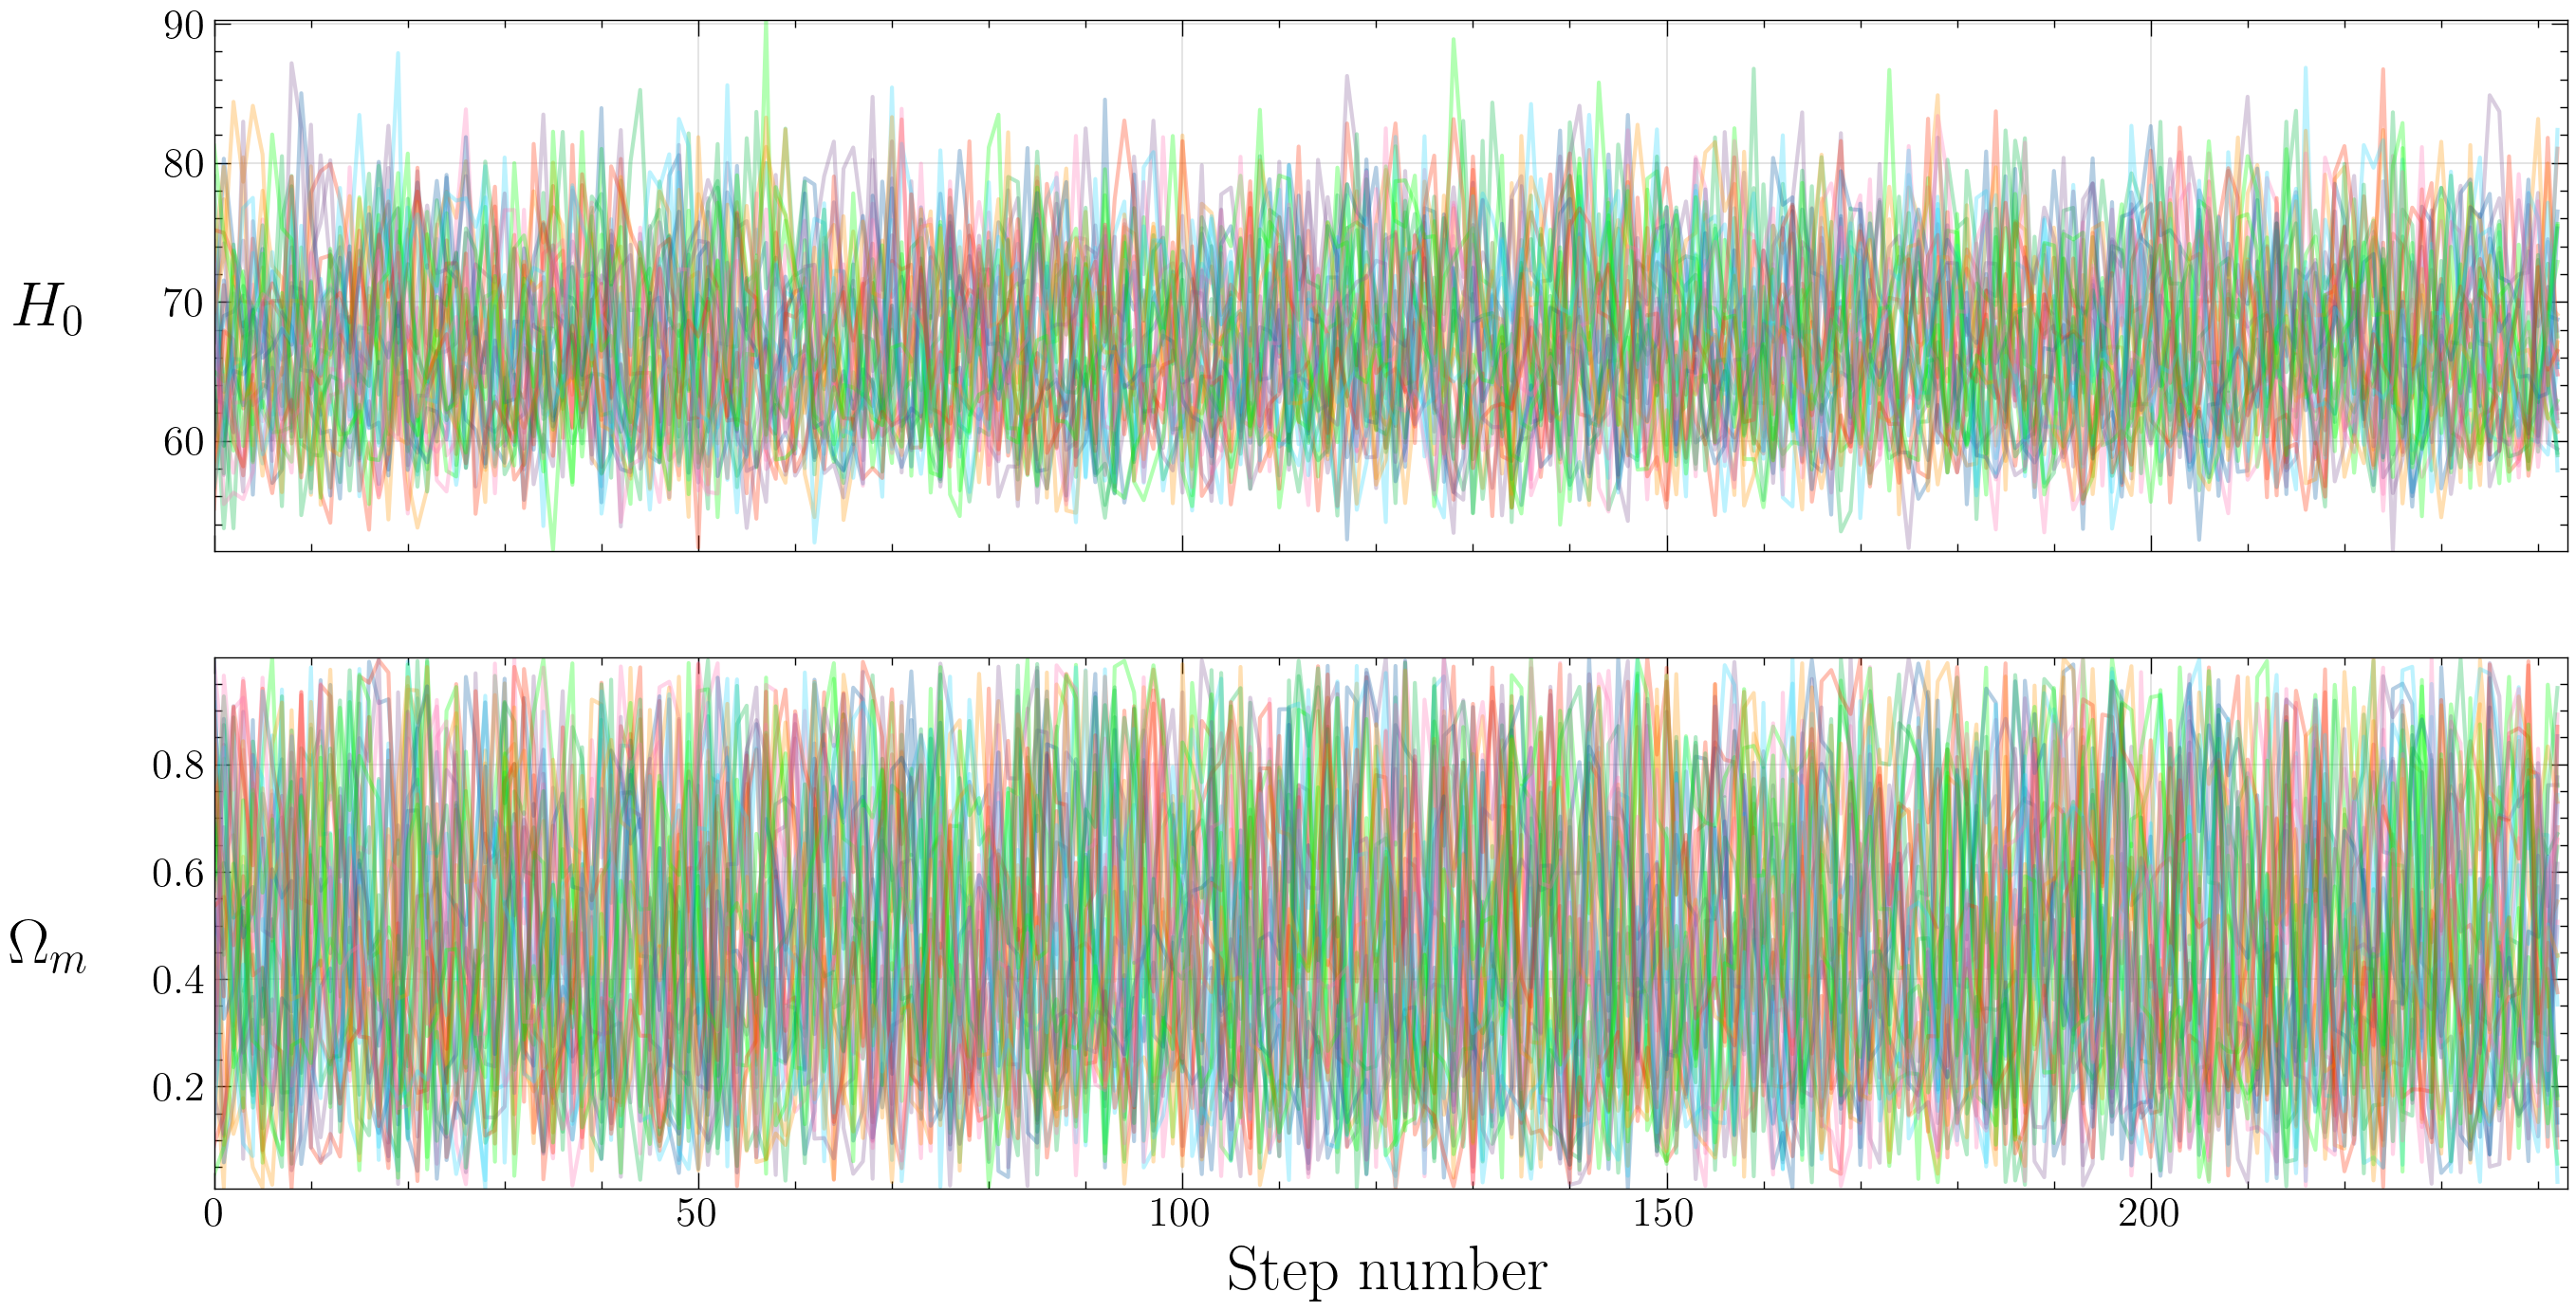

In [38]:
burn = 1000
tau = sampler.get_autocorr_time()
print(f'autocorrelation time = {tau}')
emcee_trace = sampler.get_chain(discard=burn, thin=int(np.ceil(max(tau))))

def TracePlot(trace):
    fig, axes = plt.subplots(2, figsize=(16, 8), sharex=True)
    labels = ["$H_0$","$\Omega_m$"]
    for i in range(ndim):
        ax = axes[i]
        ax.plot(trace[:, :, i], alpha=0.3)
        ax.set_xlim(0, len(trace))
        ax.set_ylim(np.min(trace[:, :, i]), np.max(trace[:, :, i]))
        ax.set_ylabel(labels[i], rotation=0)
        ax.yaxis.set_label_coords(-0.07, 0.4)
    axes[-1].set_xlabel("Step number");
    return fig, axes

fig, axes = TracePlot(emcee_trace)

emcee_trace = sampler.get_chain(discard=burn, thin=int(np.ceil(max(tau))), flat=True)
print(f'chain length = {emcee_trace.shape}')

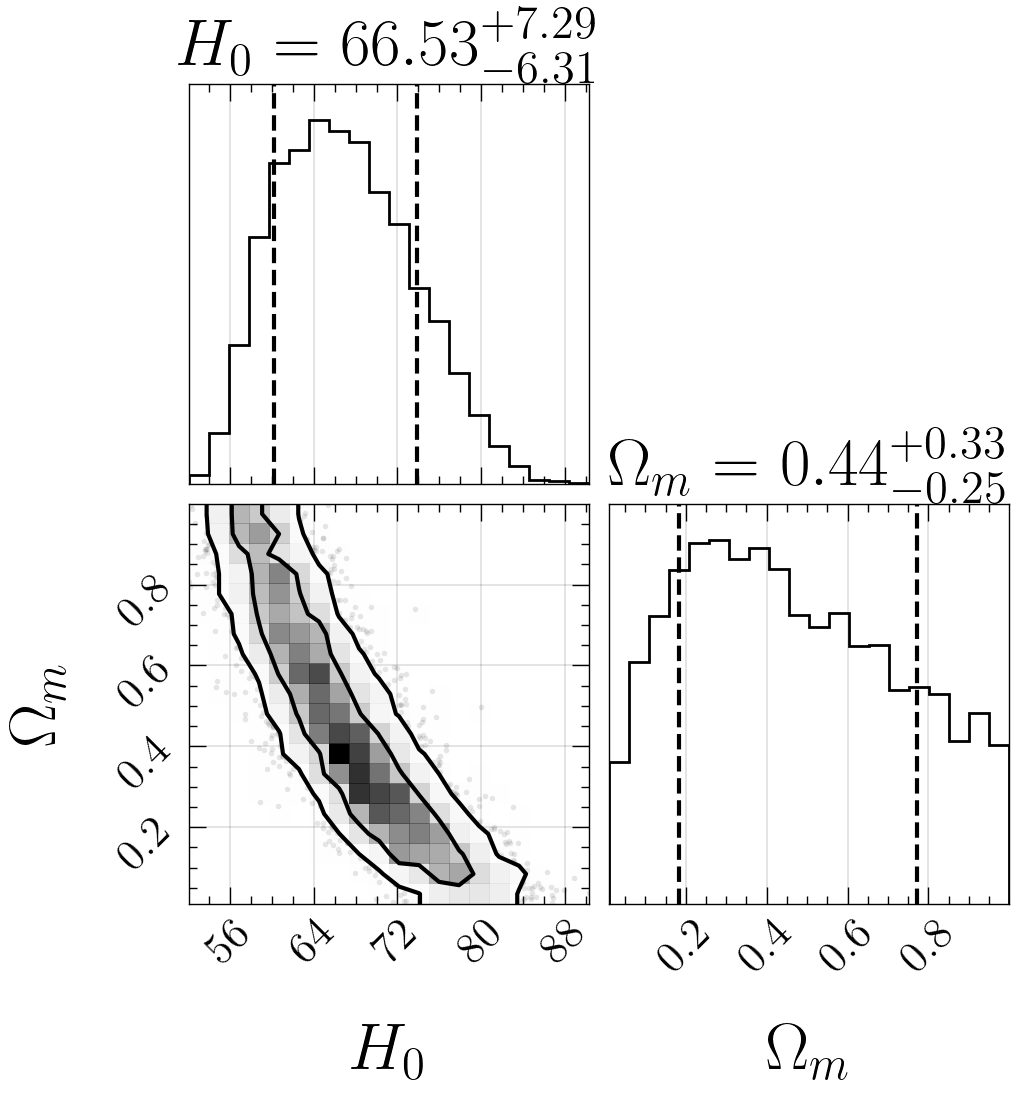

In [39]:
fig = corner.corner(emcee_trace, quantiles=(0.16, 0.84), levels=(0.68,0.95), labels=['$H_0$','$\Omega_m$'], show_titles=True)

We can see that $H_0$ and $\Omega_m$ are highly anti-correlated.

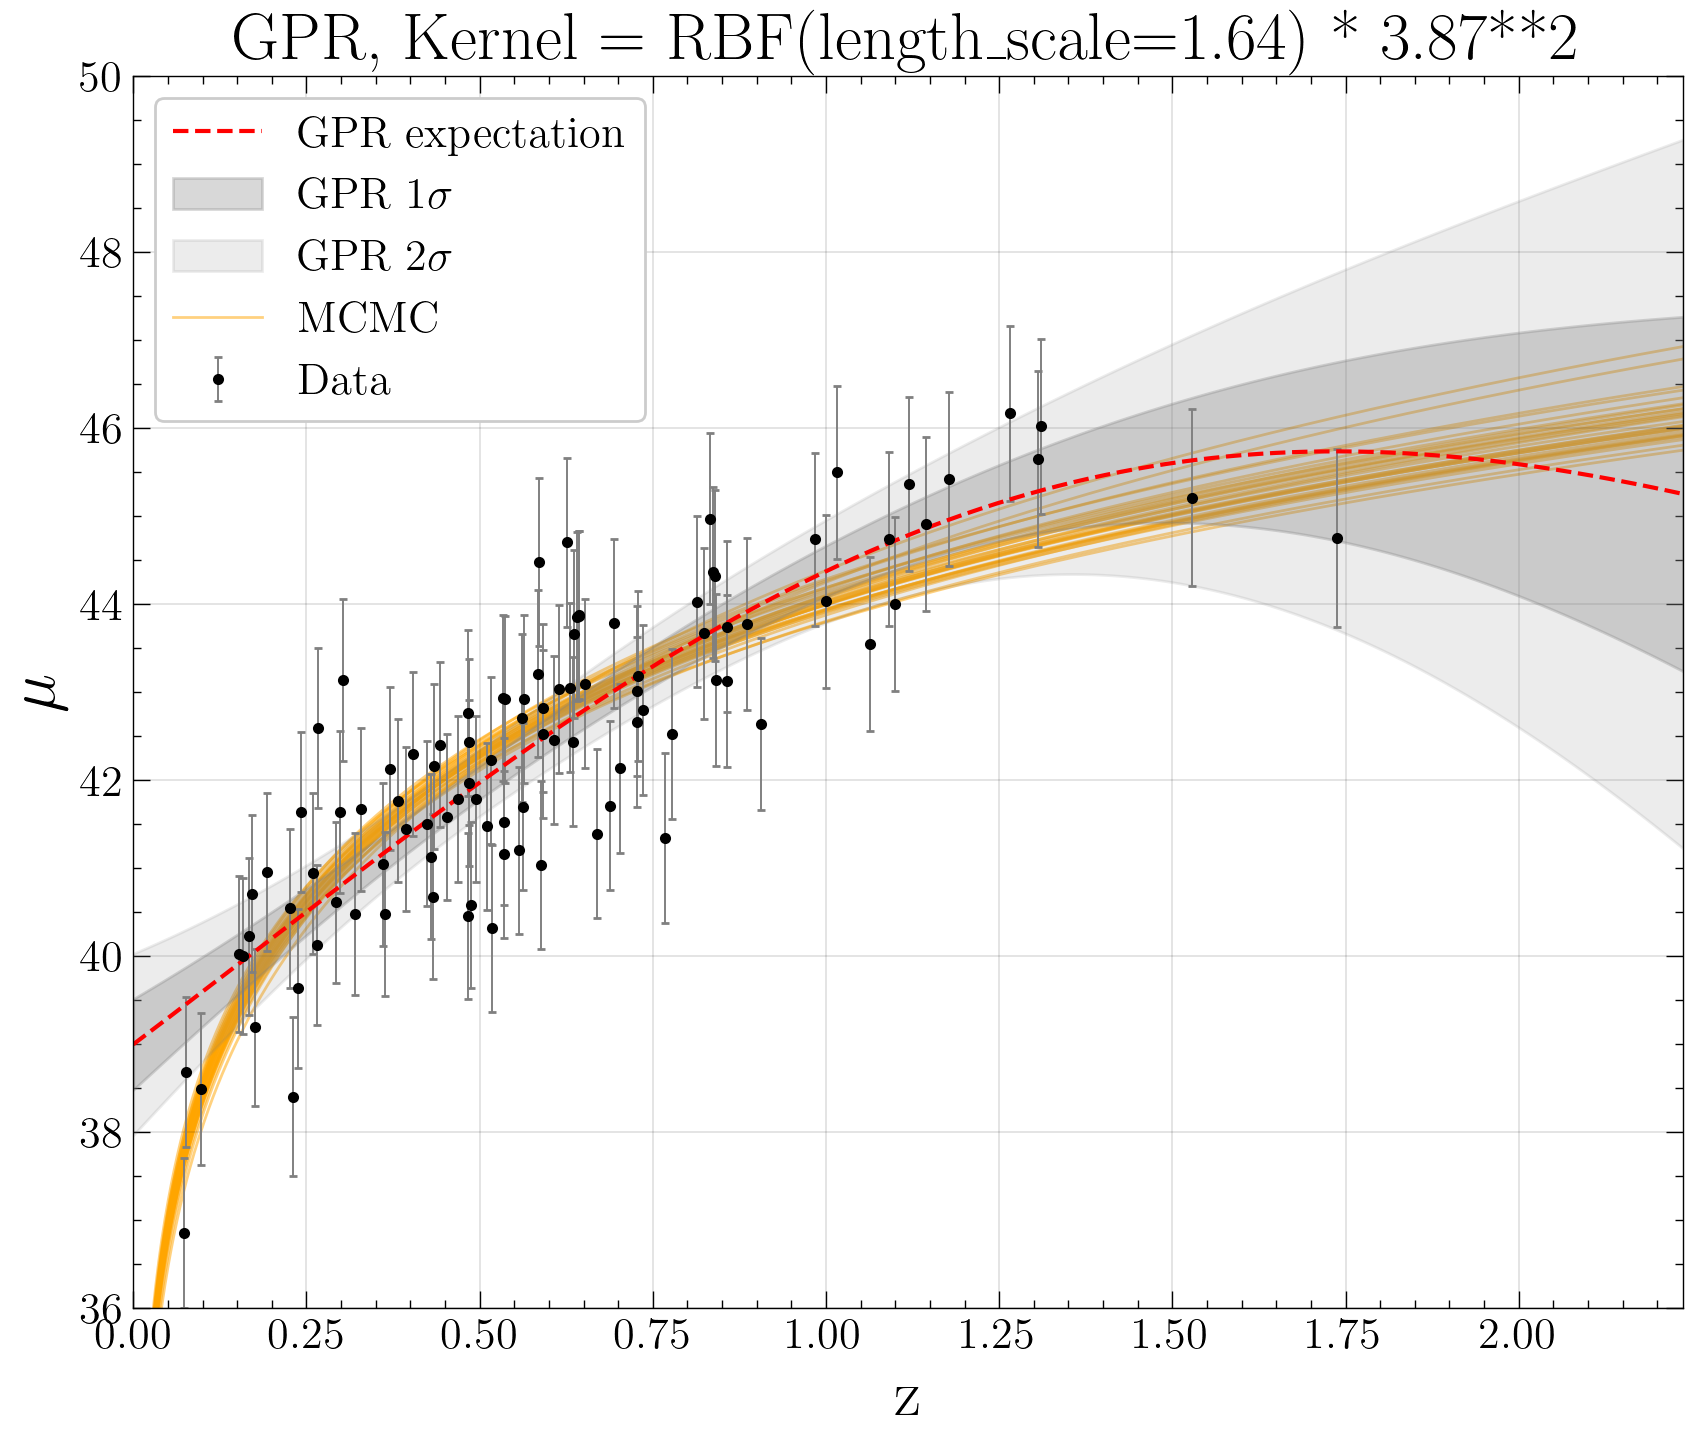

In [40]:
PlotGPR(gpr, z_sample, mu_sample, dmu)

z_dense = np.linspace(0.001, np.max(z_sample)+0.5, 1000)
samples = emcee_trace[np.random.choice(len(emcee_trace), size=30)]
sample = samples[0]
plt.plot(z_dense, mu_model(z_dense, sample[0], sample[1]), color='orange', lw=1, alpha=0.5, label='MCMC', zorder=0)
for sample in samples[1:]:
    plt.plot(z_dense, mu_model(z_dense, sample[0], sample[1]), color='orange', lw=1, alpha=0.5, zorder=0)
plt.legend();

The GPR model is quite close to the parametric one, at least where we have most of the data points.

### 2.2) Model without dark energy

Let's now see how a model without dark energy ($\Omega_m \approx 1$) would perform:

In [41]:
mask = np.isclose(emcee_trace[:,1], 1, rtol=1e-2)
emcee_trace[mask]

array([[59.52614315,  0.99248361],
       [60.61638761,  0.99909293],
       [60.91931901,  0.99108804],
       [55.93129455,  0.99396174],
       [56.89464374,  0.99663699],
       [57.94044752,  0.99162415],
       [56.70921289,  0.99254665],
       [57.96833901,  0.99129281],
       [56.35689198,  0.99499734],
       [60.47799766,  0.99874066],
       [59.46215358,  0.99543446],
       [60.93058818,  0.99394696],
       [57.27724266,  0.99082758],
       [57.5423792 ,  0.99517218],
       [55.89956804,  0.99274596],
       [57.65294723,  0.9937706 ],
       [56.344817  ,  0.99283333],
       [59.49346825,  0.99805485],
       [58.58130715,  0.99035002],
       [58.1357124 ,  0.99312207],
       [59.38398238,  0.99943624],
       [58.76041918,  0.99727961],
       [60.81724119,  0.99756808],
       [56.09230152,  0.99219421],
       [61.20775951,  0.9992483 ],
       [57.55932629,  0.99809713],
       [54.2453831 ,  0.99215079],
       [58.13450118,  0.99798958],
       [57.9351671 ,

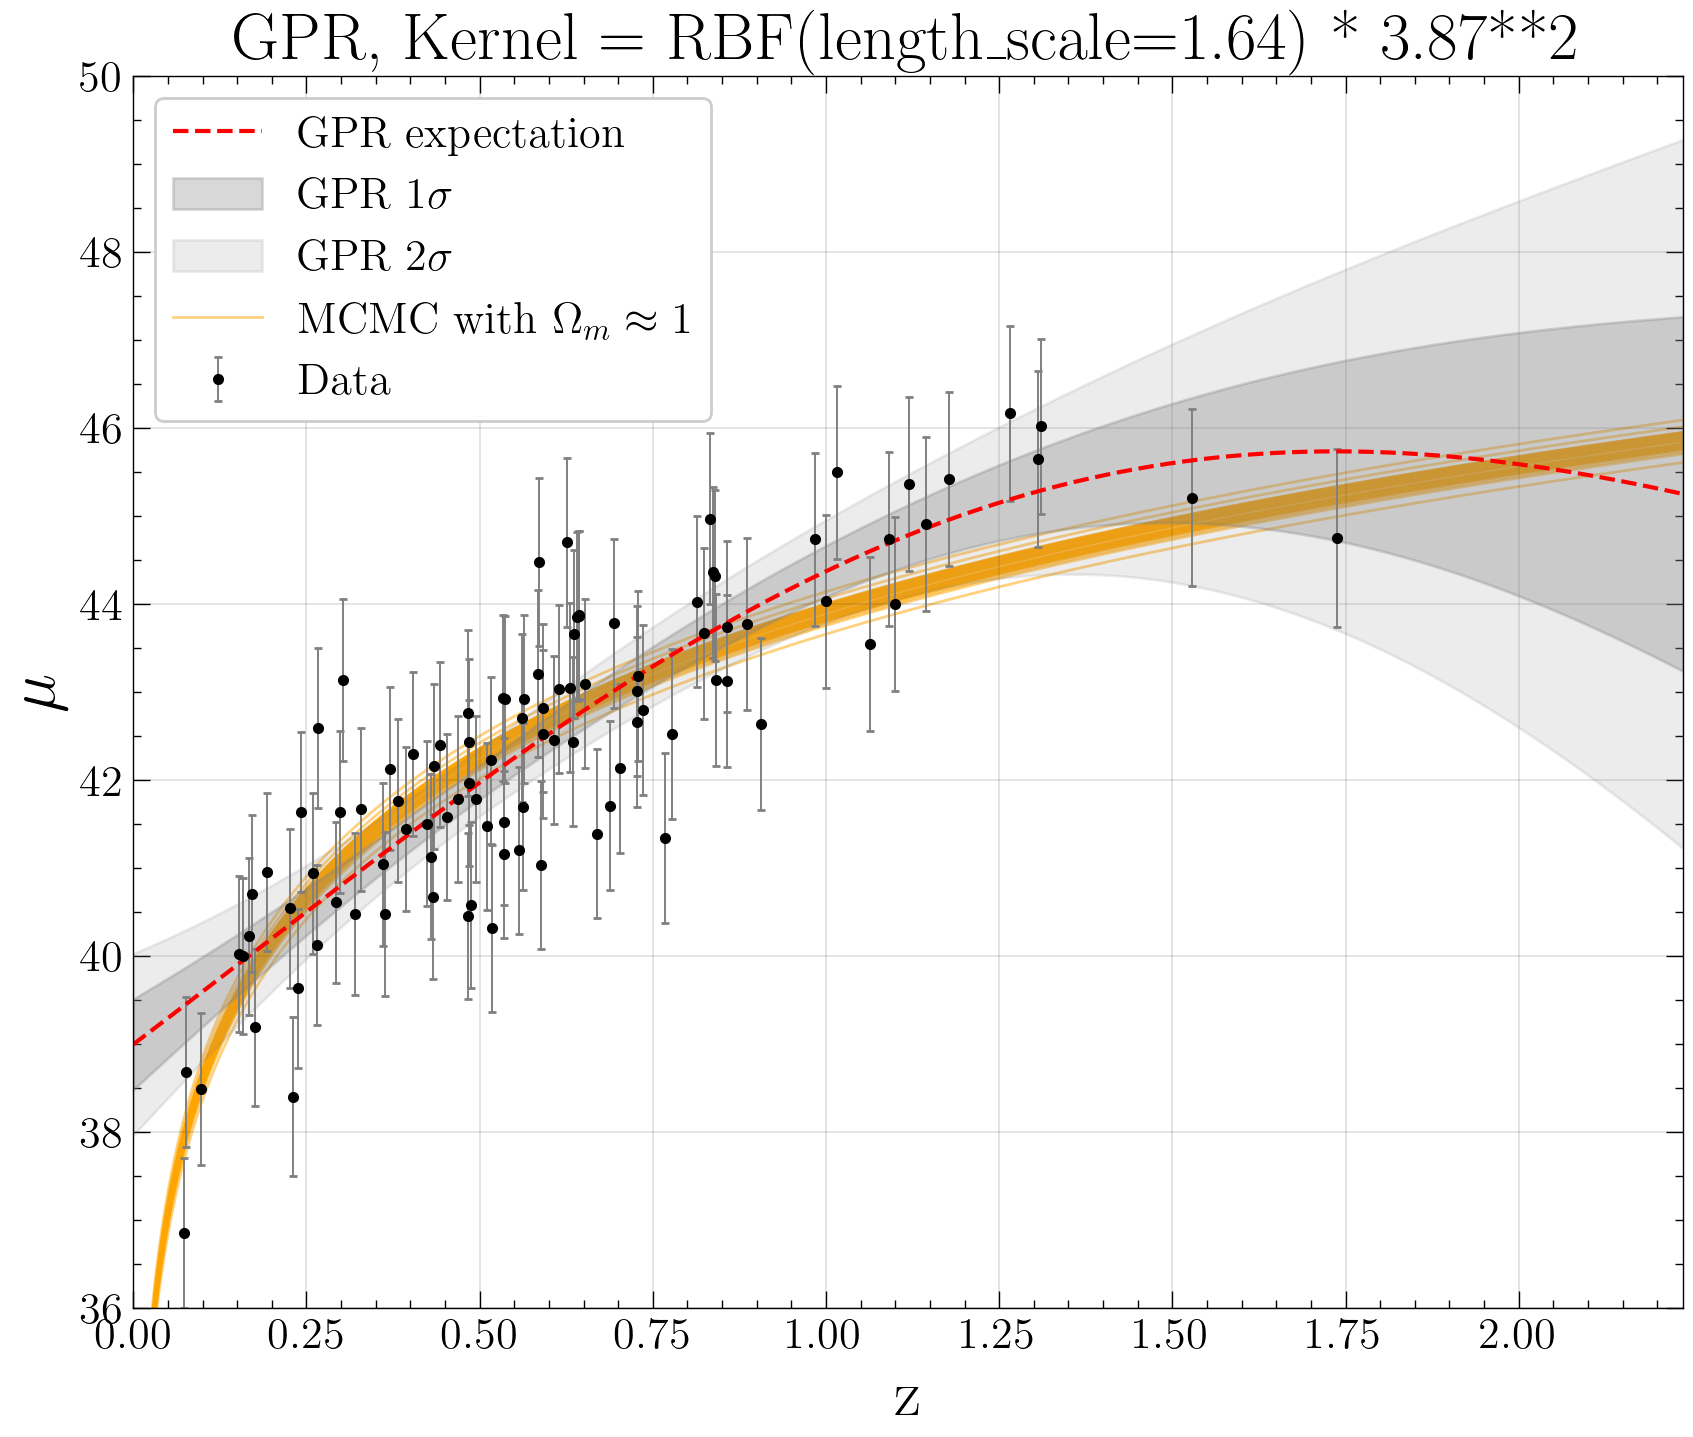

In [42]:
PlotGPR(gpr, z_sample, mu_sample, dmu)

z_dense = np.linspace(0.001, np.max(z_sample)+0.5, 1000)
samples = emcee_trace[mask]
sample = samples[0]
plt.plot(z_dense, mu_model(z_dense, sample[0], sample[1]), color='orange', lw=1, alpha=0.5, label='MCMC with $\Omega_m \\approx 1$', zorder=0)
for sample in samples[1:]:
    plt.plot(z_dense, mu_model(z_dense, sample[0], sample[1]), color='orange', lw=1, alpha=0.5, zorder=0)
plt.legend();

Actually, it is not that different from the previous fit!

Since one model is nested into the other (i.e. $M_2(H_0)=M_1(H_0, \Omega_m=1)$), we can try to estimate the Bayes factor (equal to the odds ratio, since the priors are the same) through Savage-Dickey's formula:

$$B_{1,2} = \frac{p(d | M_1)}{p(d | M_2)} = \frac{p(\Omega_m=1 | M_1)}{p(\Omega_m=1 | d, M_1)} $$

The numerator is the marginalized prior under the broad model evaluated at the constraint given by the narrow model, and the denominator is the marginalized posterior under the broad model evaluated at the constraint given by the narrow model. 

In our case, $p(H_0, \Omega_m|M_1)= \frac{1}{110-30}\frac{1}{1-0.01}$ and so $p(\Omega_m=1|M_1) = p(\Omega_m|M_1) = \frac{1}{1-0.01}$.

In order to find $p(\Omega_m=1 | d, M_1)$, we need to marginalize over $H_0$, normalize and evaluate at $\Omega_m=1$ the posterior.

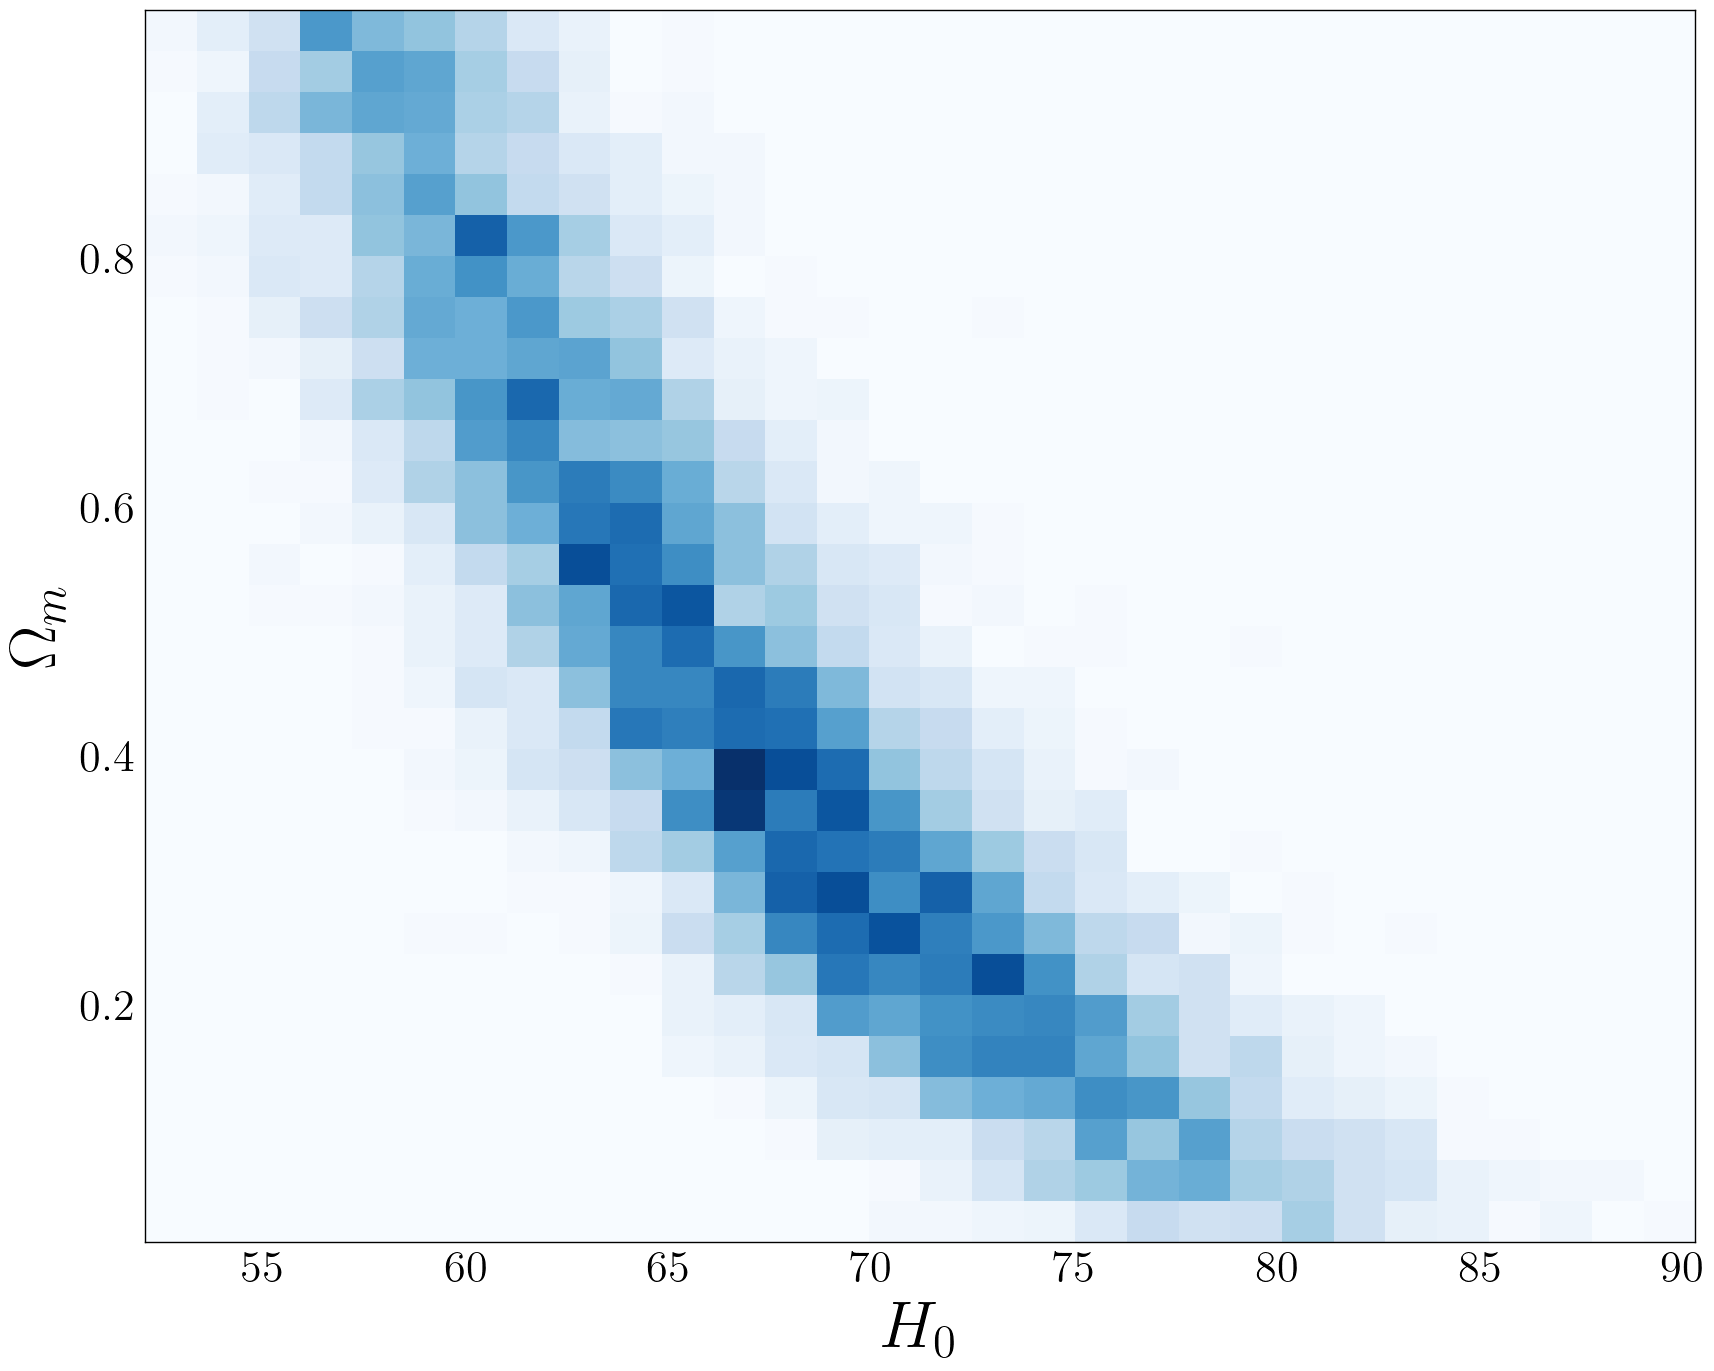

In [43]:
hist2d = plt.hist2d(emcee_trace[:,0], emcee_trace[:,1], bins=(30, 30), cmap=plt.cm.Blues)
plt.xlabel('$H_0$')
plt.ylabel('$\Omega_m$');

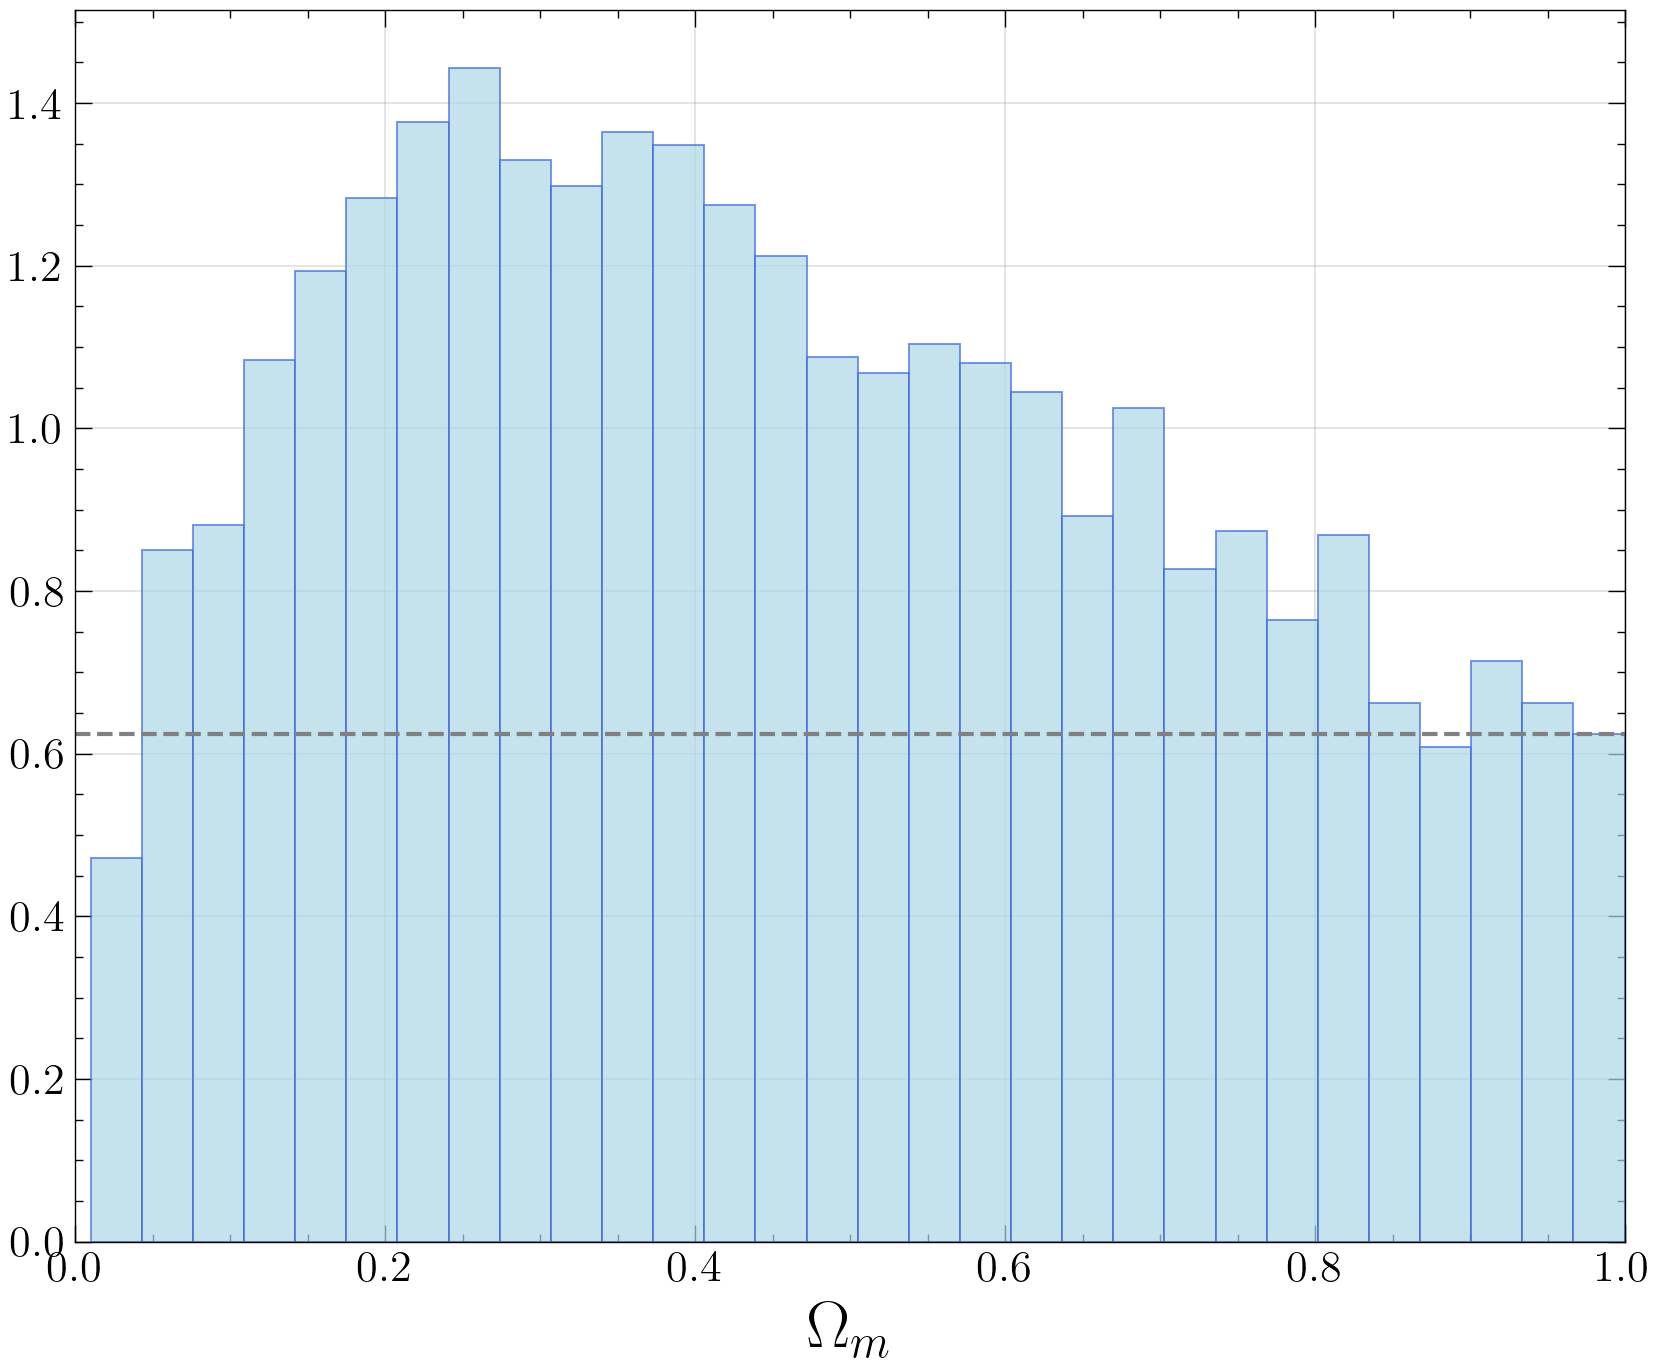

In [44]:
H0_bins_width = hist2d[1][1:] - hist2d[1][:-1]
marginalized_over_H0 = np.sum(hist2d[0]*H0_bins_width, axis=0)

OmegaM_bins_middle = (hist2d[2][:-1] + hist2d[2][1:])/2
hist = plt.hist(OmegaM_bins_middle, bins=hist2d[2], weights=marginalized_over_H0, density=True,
                color='lightblue', edgecolor='royalblue', alpha=0.7, linewidth=0.7)
plt.xlim(0, 1)
plt.xlabel('$\Omega_m$')

marginalized_over_H0_evaluated_at_1 = hist[0][-1]
plt.axhline(marginalized_over_H0_evaluated_at_1, c='gray', ls='--');

<font color='red'>Actually `plt.hist(emcee_trace[:,1])` would give the same result...</font>

In [45]:
SD_ratio = 1/(1-0.01)/marginalized_over_H0_evaluated_at_1
print(f'Savage-Dickey\'s OR = {SD_ratio:.2f}')

Savage-Dickey's OR = 1.62


An odds ratio such close to unity is inconclusive, and so we can't tell which model is the best.

## 3) Cloning data

In order to respect the statistical properties of the data we were given, we could estimate the pdf of our z samples with a KDE, then extract samples from it, and finally pass them to our GPR and parametric models.

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


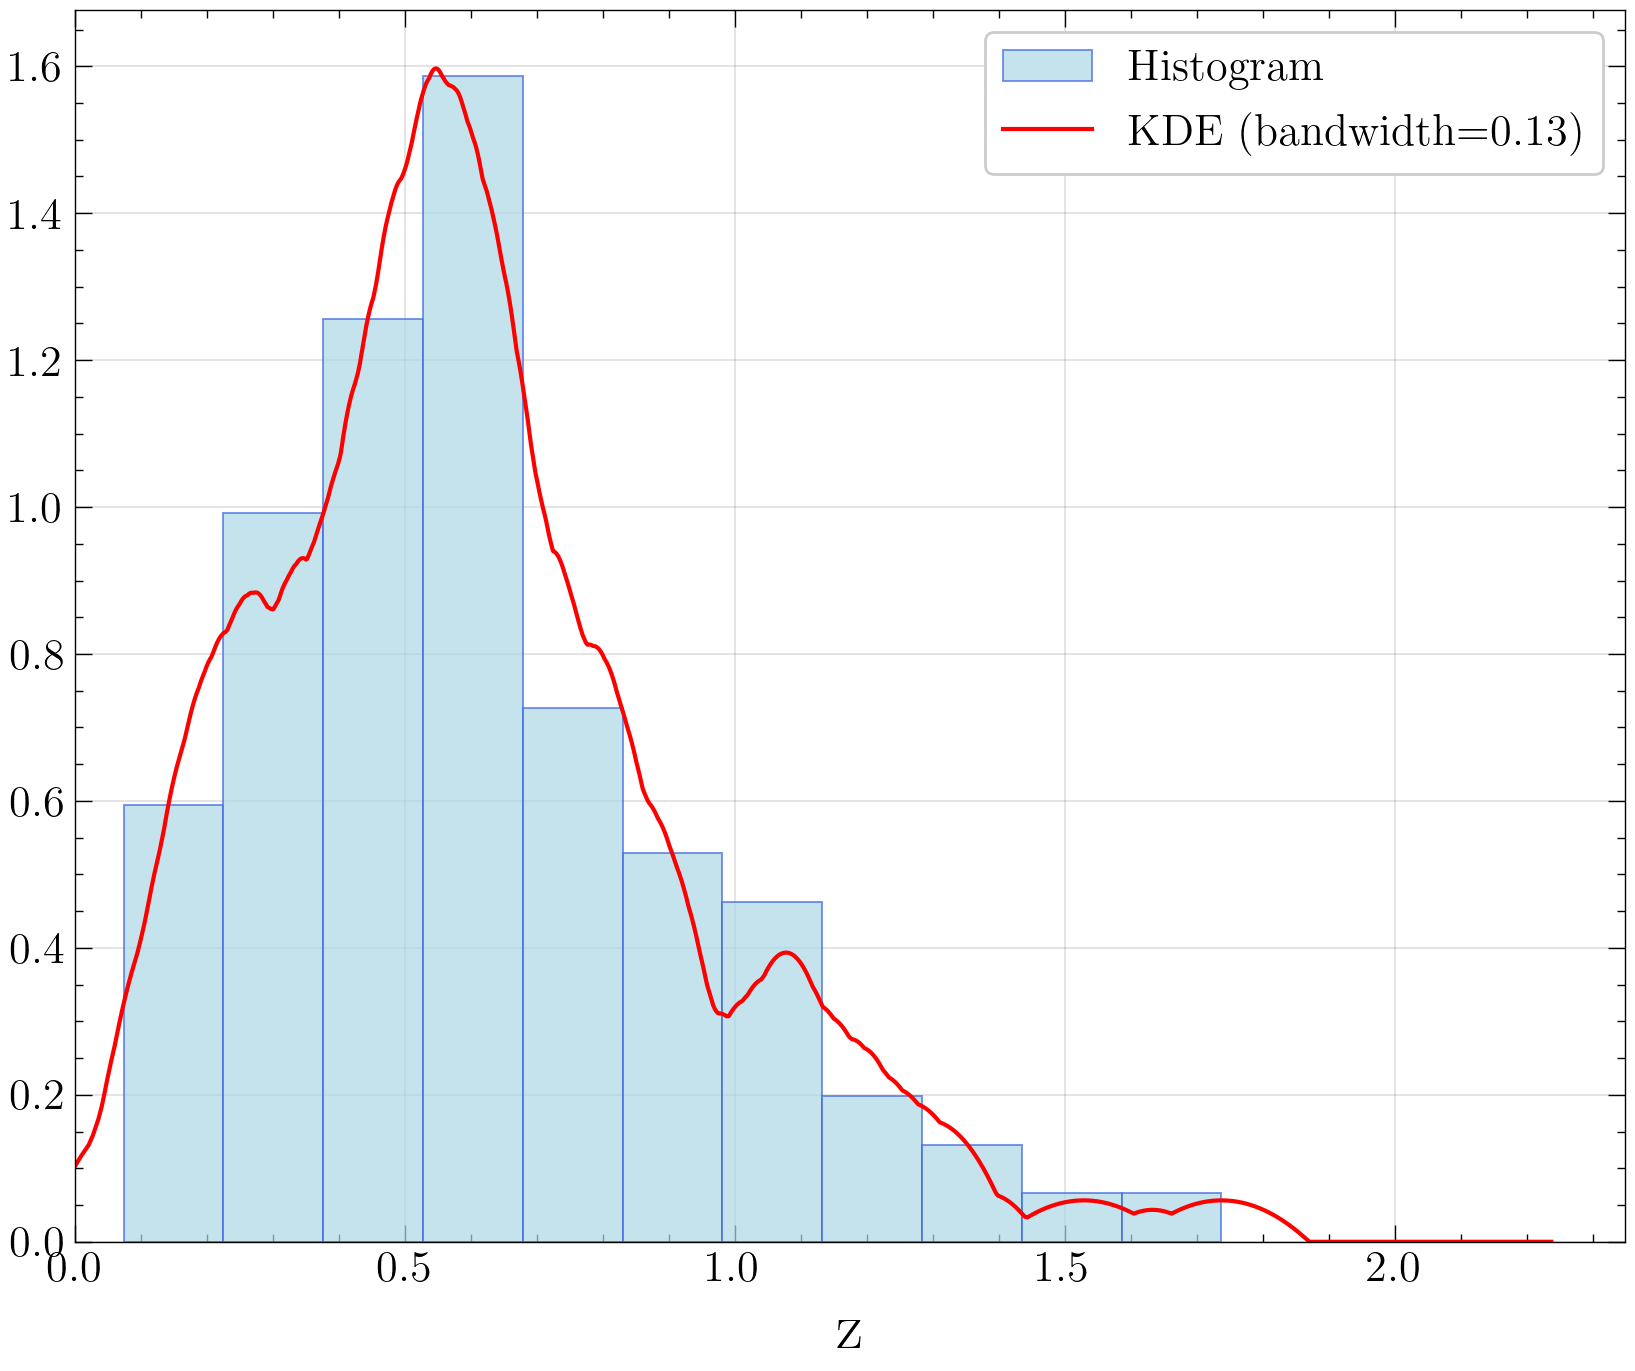

In [46]:
def KDE_Sklearn(data, x_dense, kernel, bandwidth_space, K):
    
    # Searching for the optimal bandwidth
    grid = GridSearchCV(KernelDensity(), {'bandwidth': bandwidth_space}, cv= K, n_jobs=int(mp.cpu_count()/2), verbose=True) 
    scaler = preprocessing.StandardScaler()
    grid.fit(scaler.fit_transform(data))
    bandwidth = scaler.scale_[0] * grid.best_params_['bandwidth']
    
    # Compute the KDE
    kde_skl = KernelDensity(bandwidth=bandwidth, kernel=kernel)
    kde_skl.fit(data)
    log_pdf = kde_skl.score_samples(x_dense) # Sklearn returns log(density)

    return np.exp(log_pdf), bandwidth

z_dense = np.linspace(0, np.max(z_sample)+0.5, 100000)
KDE, bandwidth = KDE_Sklearn(z_sample[:, np.newaxis], z_dense[:, np.newaxis], 'epanechnikov', np.linspace(0.05, 1, 100), 10)

plt.hist(z_sample, bins='auto', density=True,
         color='lightblue', edgecolor='royalblue', alpha=0.7, linewidth=0.7, label='Histogram');
plt.plot(z_dense, KDE, c='red', label=f'KDE (bandwidth={bandwidth:.2f})')
plt.xlim(0)
plt.xlabel('z')
plt.legend();

Let's sample the KDE of z via rejection sampling

In [47]:
y_max = np.max(KDE)

N = int(5e3)

z_dense_indices = np.arange(0, len(z_dense))
x_indices = np.random.choice(z_dense_indices, N)
x = z_dense[x_indices]
y = np.random.uniform(0, y_max, N)
  
new_z_sample = x[y <= KDE[x_indices]]
    
print(len(new_z_sample))

1387


In [48]:
mu_gpr = []
mu_parametric = []

for z in new_z_sample:
    mean_gpr, sigma_gpr = gpr_fitted.predict([[z]], return_std=True)
    mu_gpr.append(np.random.normal(loc=mean_gpr, scale=sigma_gpr))
    
    H0, OmegaM = emcee_trace[np.random.choice(emcee_trace.shape[0])]
    mu_parametric.append(mu_model(z, H0, OmegaM))

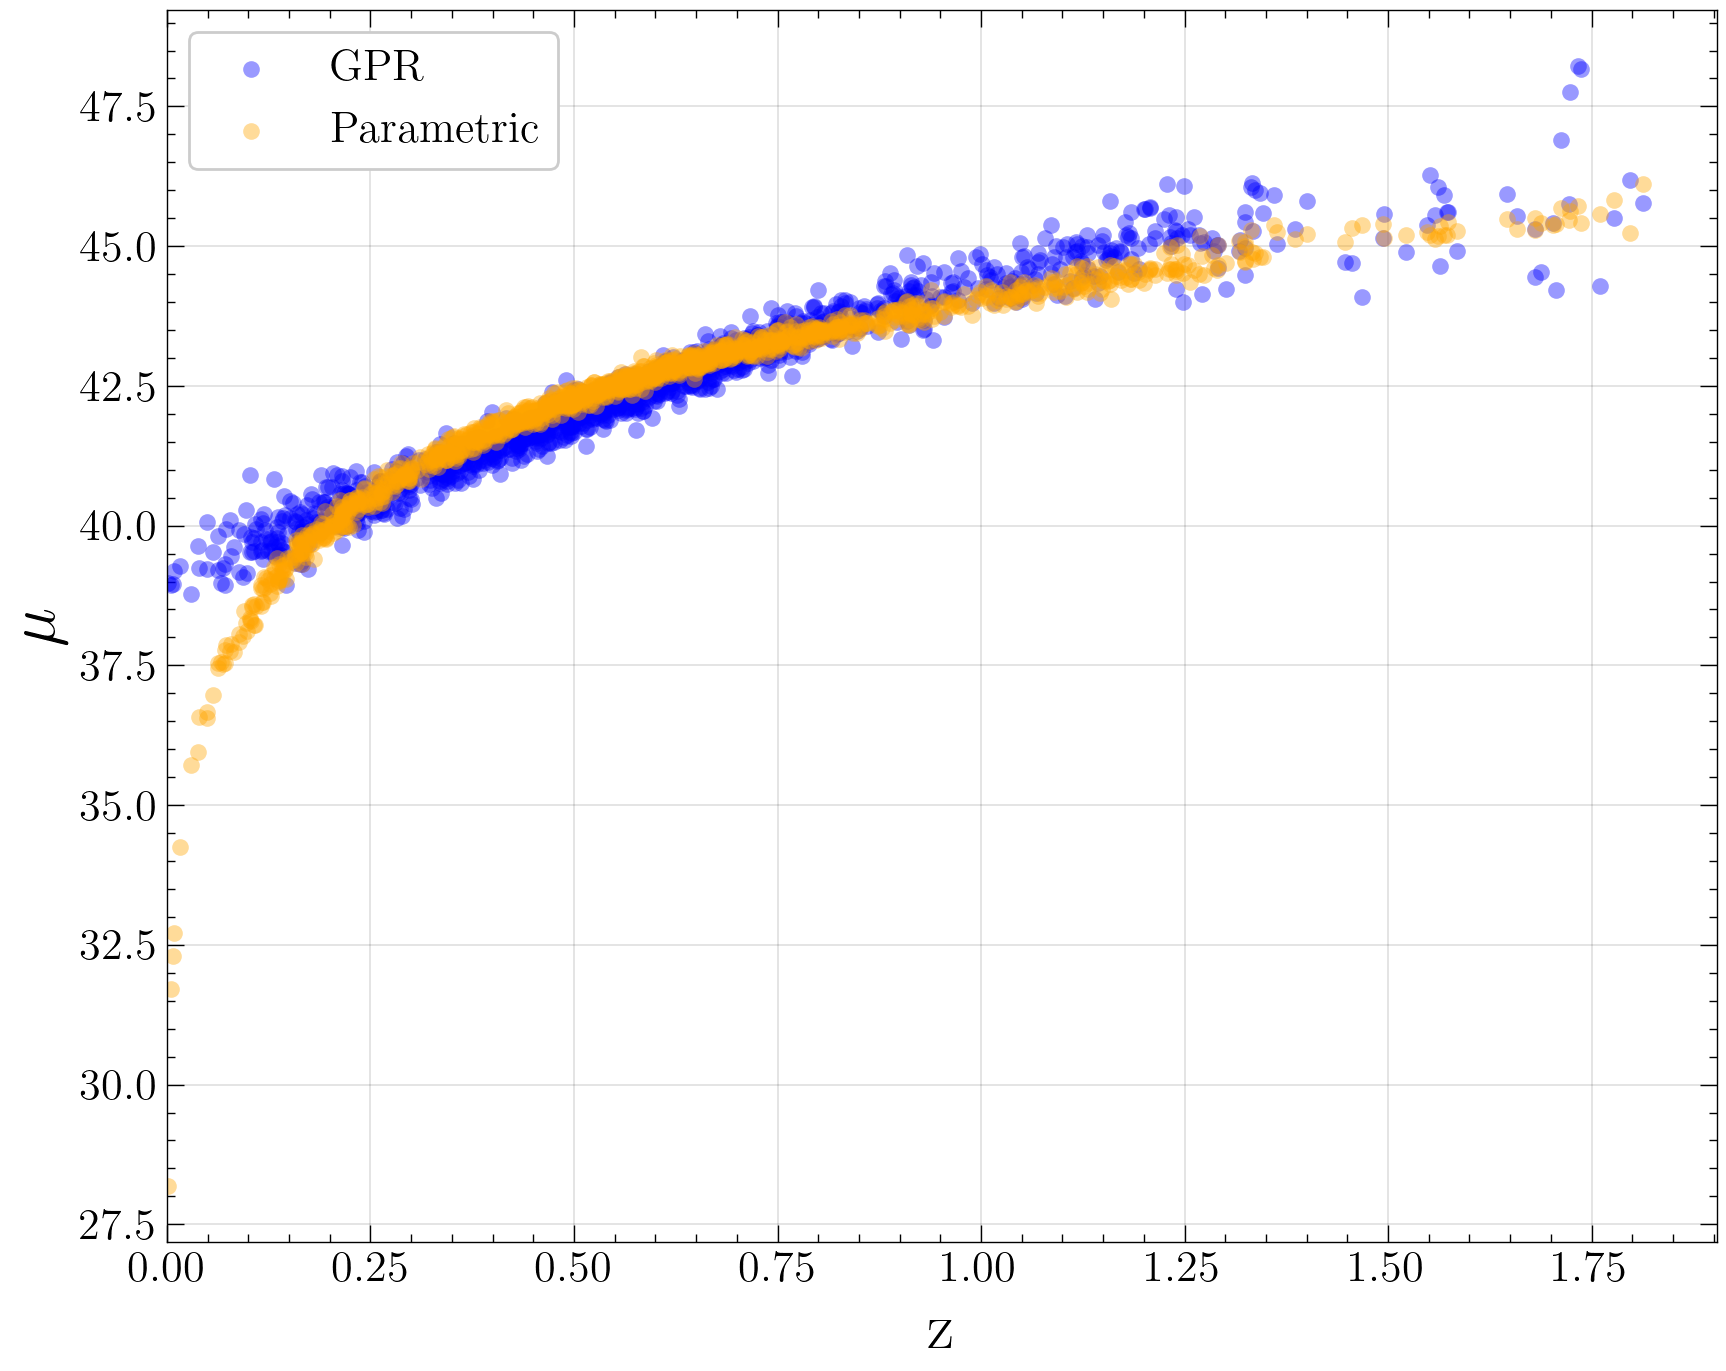

In [49]:
plt.scatter(new_z_sample, mu_gpr, c='blue', alpha=0.4, linewidths=0, label='GPR')
plt.scatter(new_z_sample, mu_parametric, c='orange', alpha=0.4, linewidths=0, label='Parametric')
plt.xlim(0)
plt.xlabel('z')
plt.ylabel('$\mu$')
plt.legend();